* school - 이진 - 학교 - "GP", "MS"
* sex - 이진 - 남여 - "F", "M"
* age - int - 나이 - 15~22
* address - 이진 - 도시/시골 - "U", "R"
* famsize - 이진 - 가족인원 작/크 -'LE3''GT3'
* Pstatus - 이진 - 부모님과 함께/따로 - "T", "A"
<br></br>
    (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
* Mjob - 명목 - 모 직업
* Fjob - 명목 - 부 직업
<br></br>
* reason - 명목 - 학교를 선택한 이유 - 'home' 'reputation' 'course','other')
* guardian - 명목 - 보호자 - 'mother','father','other'
<br></br>
    (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – * higher education)
* Medu - int - 모 최종학력
* Fedu - int - 부 최종학력
<br></br>
* traveltime - int - 통학시간 - (1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
* studytime - int - 주당 공부시간 ( 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
* failures - int - 낙제 횟수 - 1,2,3 4~
* absences - int - 결석 횟수 - numeric: from 0 to 93)
<br></br>
     (yes or no)
* schoolsup - 이진 - 추가 교육 지원
* famsup - 이진 - 부모 교육 지원
* paid - 이진 - 사교육여부
* activities - 이진 - 교과 외 활동
* nursery - 이진 - 보육원 출신
* higher - 이진 - 목표의식
* internet - 이진 - 인터넷
* romantic - 이진 - 연애
<br></br>
    (1 - very bad to 5 - excellent)
* famrel - int - 가족들의 관계
* freetime - int - 방과후 남는시간
* goout - int - 친구들과 놀러가기
* Dalc - int - 평일 알콜소비
* Walc - int - 주말 알콜소비
* health - int - 건강상태
<br></br>
* GT_Mat - int - 1~3학년 총점
* G1_Mat - int - 1학년 점수 
* G2_Mat - int - 2학년 점수
* G3_Mat - int - 3학년 점수
<br></br>
* GT_rank - int - 1~3학년 총점 등수
* G1_rank - int - 1학년 총점 등수
* G2_
rank - int - 2학년 총점 등수
* G3_rank - int - 3학년 총점 등수
<br></br>
    등급표 9단계 [-4,-11,-23,-40,-60,-77,-89,-96,-100]
* GT_rank_bin - int - 1~3학년 총점 등급
* G1_rank_bin - int - 1학년 등급
* G2_rank_bin - int - 2학년 등급
* G3_rank_bin - int - 3학년 등급

# 환경설정

In [300]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')
pd.options.display.max_columns = 50

import matplotlib.pyplot as plt
import seaborn as sns

from pandas.api.types import CategoricalDtype

import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, normalize
from sklearn.metrics import mean_squared_error

import matplotlib.gridspec as gridspec
sns.set(rc = {"figure.figsize" : (15,8)})
sns.set_style('white')
plt.rc("axes", unicode_minus=False) # 음수값 깨지는 폰트 설정
plt.rc('font', family='NanumBarunGothic')

RANDOM_SEED = 42

## helper

In [152]:
def distribution_by(data,feature,target, size=(6,4),fig=True, title=None,wp=True):
    if fig:
        plt.figure(figsize=size)
    ax = sns.countplot(x=feature,
                 data=data,
                 hue = target,
                 palette="husl")
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f"{feature} Distribution by {target}")
    ax.legend(title=target,title_fontsize="small",fontsize="small")
    
    for idx in range(len(ax.patches)):
        ax.patches[idx].set_color(sns.husl_palette(len(ax.patches))[idx])
        
    if wp:
        write_percent(ax, len(data))
        
def write_percent(ax, total_size):
    # total_size는 데이터의 길이 len(df) 를 사용하면 된다.
    
    # patch 그래프 막대 0~
    for idx, patch in enumerate(ax.patches):
        height = patch.get_height() # 높이(데이터 개수)
        width = patch.get_width() # 너비
        left_coord = patch.get_x() # 왼족 테두리의 x 좌표
        percent = height/total_size*100 # 타겟값 비율
        if percent >=2:
            ax.text(x=left_coord + width/2.0, # x 축 위치
                    y=height+total_size*0.003, # y 축 위치
                    s=f"{percent : 1.1f}%", # 입력될 텍스트
                    ha="center") # 가운데 정렬

def get_crosstab(df, feature, target="target"):
    # 교차분석표
    crosstab = pd.crosstab(df[feature], df[target], normalize="index")*100
    crosstab = crosstab.reset_index()
    return crosstab

def plot_pointplot(ax, feature, crosstab):
    
    # 이미 그려진 countplot 위에 덧그리기 
    ax2= ax.twinx() # x 축은 공유하고 y 축은 공유하지 않는 새로운 축
    #새로운 축에 plot 그리기
    ax2= sns.pointplot(x=feature, y=1, data=crosstab,
                      order=crosstab[feature].values, # 포인트 플롯의 순서
                      color="black") # 범례표시 x
    ax2.set_ylim(crosstab[1].min()-5, crosstab[1].max()*1.1)
    ax2.set_ylabel("Target 1 Ratio (%)")
    
def plot_cat_dist_with_true_ratio(df, features, num_rows, num_cols, target="target",size=(15,20)):

    import matplotlib.gridspec as gridspec

    plt.figure(figsize=size) # 전체 그래프의 크기
    grid = gridspec.GridSpec(num_rows, num_cols) #  서브플롯 배치
    plt.subplots_adjust(wspace=0.45, hspace=0.3) # 좌우/ 상하 여백
    
    for idx, feature in enumerate(features):
        ax = plt.subplot(grid[idx]) # x 번째 grid 그래프
        crosstab = get_crosstab(df, feature, target=target) # 교차 분석표 작성
        
        # ax축에 그래프 그리기
        sns.countplot(x=feature, data=df,
                     order=crosstab[feature].values,
                     ax=ax)
        for idx in range(len(ax.patches)):
            ax.patches[idx].set_color(sns.husl_palette(len(ax.patches))[idx])
        write_percent(ax, len(df)) # 비율 표시
        plot_pointplot(ax, feature, crosstab) # ax2축에 포인트 플랏그리기
        ax.set_title(f"{feature} Distribution") # 타이틀 설정
        
def ordinal_encoding(all_data, features):
    from sklearn.preprocessing import OrdinalEncoder

    ord_encoder = OrdinalEncoder()

    all_data[features] = ord_encoder.fit_transform(all_data[features])

    for feature, categories in zip(features, ord_encoder.categories_):
        print(feature)
        print(categories)
    return all_data

def plot_target_ratio_by_features(df, features, num_rows, num_cols, target="target",size=(12,18)):
    

    import matplotlib.pyplot as plt
    import seaborn as sns
    import matplotlib.gridspec as gridspec
    
    plt.rc("font", size=8)
    plt.figure(figsize=size)
    grid = gridspec.GridSpec(num_rows, num_cols)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    for idx, features in enumerate(features):
        ax = plt.subplot(grid[idx])
        sns.barplot(x=features, y=target, data=df, palette="Set2", ax=ax)
        for idx in range(len(ax.patches)):
            ax.patches[idx].set_color(sns.husl_palette(len(ax.patches))[idx])

def rmse_exp(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_true), np.expm1(y_pred)))
        

def get_FI_lgb(X_train, y_train, lgb_param):

    folds = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    oof = np.zeros(len(X_train))
    feature_importance_df = pd.DataFrame()
    params = {'verbose': -1}
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
        trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx], params=params)
        val_data = lgb.Dataset(X_train.iloc[val_idx], label=y_train.iloc[val_idx])
        num_round = 100000
        clf = lgb.train(lgb_param, trn_data, num_round, valid_sets=[trn_data, val_data],
                        verbose_eval=False, early_stopping_rounds=200)
        oof[val_idx] = clf.predict(X_train.iloc[val_idx], num_iteration=clf.best_iteration)       
        cv_fold_score = rmse_exp(y_train.iloc[val_idx], oof[val_idx])
        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature'] = X_train.columns.tolist()
        fold_importance_df['importance'] = clf.feature_importance('gain')
        fold_importance_df['fold'] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    cv_score = rmse_exp(y_train, oof)
    print(f'CV-Score: {cv_score:.6f}')
    return feature_importance_df

## 데이터

In [101]:
math = pd.read_csv("math.csv")
port = pd.read_csv("port.csv")
both = pd.read_csv("both.csv")
both_bin = pd.read_csv("both_bin.csv")

In [8]:
math.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1_math', 'G2_math', 'G3_math',
       'GT_math', 'G1_scale_math', 'G2_scale_math', 'G3_scale_math',
       'GT_scale_math', 'G1_scale_math.1', 'G2_scale_math.1',
       'G3_scale_math.1', 'GT_scale_math.1', 'G1_math_rank', 'G2_math_rank',
       'G3_math_rank', 'GT_math_rank', 'G1_math_rank_bin', 'G2_math_rank_bin',
       'G3_math_rank_bin', 'GT_math_rank_bin'],
      dtype='object')

In [9]:
both.columns

Index(['sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob',
       'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures',
       'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher',
       'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc',
       'health', 'absences', 'G1', 'G2', 'G3', 'G1_scale', 'G2_scale',
       'G3_scale', 'subject', 'GT_scale', 'G1_scale_rank', 'G2_scale_rank',
       'G3_scale_rank', 'GT_scale_rank', 'G1_scale_rank_bin',
       'G2_scale_rank_bin', 'G3_scale_rank_bin', 'GT_scale_rank_bin'],
      dtype='object')

In [10]:
both_bin.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences_x', 'G1_math', 'G2_math', 'G3_math',
       'GT_math', 'G1_scale_math', 'G2_scale_math', 'G3_scale_math',
       'GT_scale_math', 'G1_math_rank', 'G2_math_rank', 'G3_math_rank',
       'GT_math_rank', 'G1_math_rank_bin', 'G2_math_rank_bin',
       'G3_math_rank_bin', 'GT_math_rank_bin', 'absences_y', 'G1_port',
       'G2_port', 'G3_port', 'GT_port', 'G1_scale_port', 'G2_scale_port',
       'G3_scale_port', 'GT_scale_port', 'G1_port_rank', 'G2_port_rank',
       'G3_port_rank', 'GT_port_rank', 'G1_port_rank_bin', 'G2_port_rank_bin',
       'G3_port_rank_bin', 'GT_port_rank_bin'],
      dtype='object')

# 성적 데이터 분포 확인

## 전체 성적데이터의 정규화 영향

* 수학, 국어에서 1,2,3,Total 학년의 성적을 각각 MinMax로 정규화하고 시각화 합니다

In [24]:
math

school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0       GP   F   18       U     GT3       A     4     4   at_home   teacher   
1       GP   F   17       U     GT3       T     1     1   at_home     other   
2       GP   F   15       U     LE3       T     1     1   at_home     other   
3       GP   F   15       U     GT3       T     4     2    health  services   
4       GP   F   16       U     GT3       T     3     3     other     other   
..     ...  ..  ...     ...     ...     ...   ...   ...       ...       ...   
390     MS   M   20       U     LE3       A     2     2  services  services   
391     MS   M   17       U     LE3       T     3     1  services  services   
392     MS   M   21       R     GT3       T     1     1     other     other   
393     MS   M   18       R     LE3       T     3     2  services     other   
394     MS   M   19       U     LE3       T     1     1     other   at_home   

     reason guardian  traveltime  studytime  failures schoolsup famsup paid  \
0    course   mother           2          2         0       yes     no   no   
1    course   father           1          2         0        no    yes   no   
2     other   mother           1          2         3       yes     no  yes   
3      home   mother           1          3         0        no    yes  yes   
4      home   father           1          2         0        no    yes  yes   
..      ...      ...         ...        ...       ...       ...    ...  ...   
390  course    other           1          2         2        no    yes  yes   
391  course   mother           2          1         0        no     no   no   
392  course    other           1          1         3        no     no   no   
393  course   mother           3          1         0        no     no   no   
394  course   father           1          1         0        no     no   no   

    activities nursery higher internet romantic  famrel  freetime  goout  \
0           no     yes    yes       no       no       4         3      4   
1           no      no    yes      yes       no       5         3      3   
2           no     yes    yes      yes       no       4         3      2   
3          yes     yes    yes      yes      yes       3         2      2   
4           no     yes    yes       no       no       4         3      2   
..         ...     ...    ...      ...      ...     ...       ...    ...   
390         no     yes    yes       no       no       5         5      4   
391         no      no    yes      yes       no       2         4      5   
392         no      no    yes       no       no       5         5      3   
393         no      no    yes      yes       no       4         4      1   
394         no     yes    yes      yes       no       3         2      3   

     Dalc  Walc  health  absences  G1_math  G2_math  G3_math  GT_math  \
0       1     1       3         6        5        6        6       17   
1       1     1       3         4        5        5        6       16   
2       2     3       3        10        7        8       10       25   
3       1     1       5         2       15       14       15       44   
4       1     2       5         4        6       10       10       26   
..    ...   ...     ...       ...      ...      ...      ...      ...   
390     4     5       4        11        9        9        9       27   
391     3     4       2         3       14       16       16       46   
392     3     3       3         3       10        8        7       25   
393     3     4       5         0       11       12       10       33   
394     3     3       5         5        8        9        9       26   

     G1_scale_math  G2_scale_math  G3_scale_math  GT_scale_math  \
0        -1.782467      -1.254791      -0.964934      -1.404761   
1        -1.782467      -1.520979      -0.964934      -1.498193   
2        -1.179147      -0.722415      -0.090739      -0.699294   
3         1.234133       0.874715       1.002004

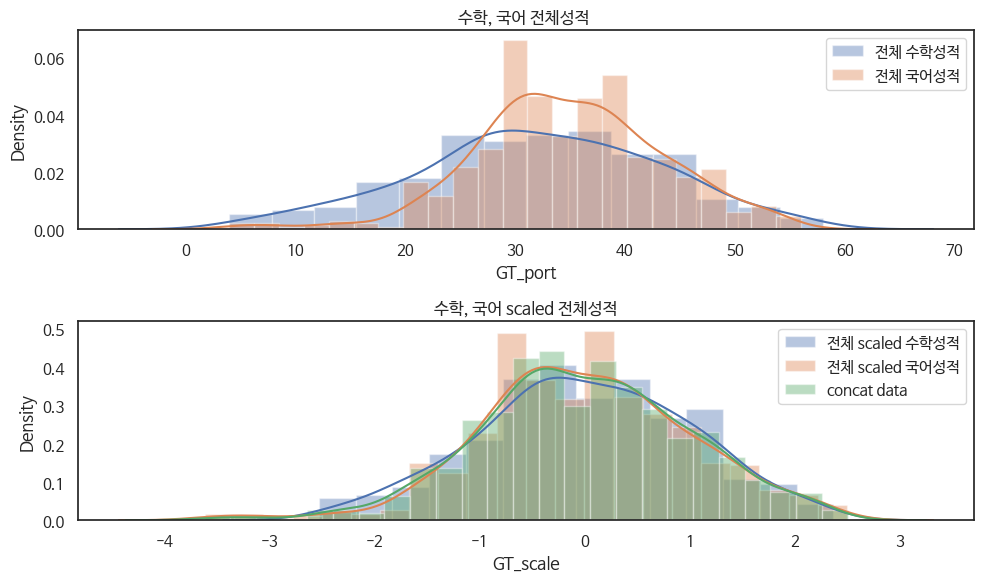

In [26]:
# 성적 분포
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
sns.distplot(math["GT_math"], label="전체 수학성적")
sns.distplot(port["GT_port"], label="전체 국어성적")
plt.title("수학, 국어 전체성적 ")
plt.legend()

plt.subplot(2,1,2)
sns.distplot(math["GT_scale_math"], label="전체 scaled 수학성적")
sns.distplot(port["GT_scale_port"], label="전체 scaled 국어성적")
sns.distplot(both["GT_scale"],label="concat data")
plt.title("수학, 국어 scaled 전체성적")
plt.legend()

plt.tight_layout()
plt.show()

## 수학 - 국어 성적분포

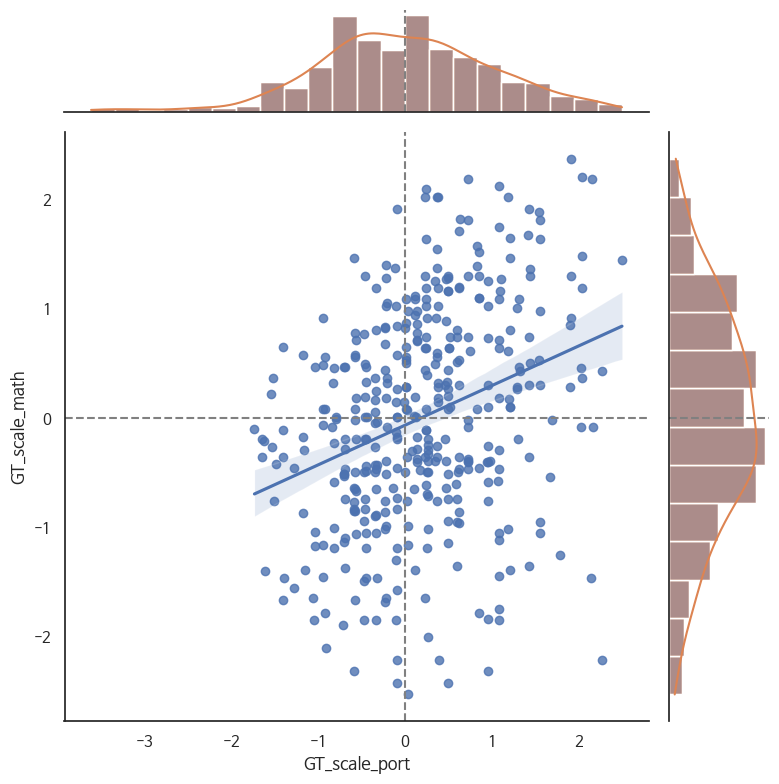

In [12]:
g = sns.JointGrid(x=port["GT_scale_port"], y=math["GT_scale_math"],height=8)
g.plot(sns.regplot, sns.histplot)
g.plot_marginals(sns.histplot, kde=True)
g.refline(x=0, y=0)

* 수학과 국어 모두 평균 30점을 기준으로 분포되어 있는 것을 볼 수 있다.
* 수학에서 점수 분포가 국어에 비해 낮은곳에 있는것을 볼 수 있다.

## 성적 회귀에 중요변수 추출

In [364]:
## 종속변수 추출
X_math = math[['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'absences']]

X_port = port[['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'absences']]

X_both = both[['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'absences']]

y_math = math["GT_scale_math"]

y_port = port["GT_scale_port"]

y_both = both["GT_scale"]

## 파라미터 설정
lgb_param = {
    'objective': 'regression',
    'learning_rate': 0.05,
    'num_leaves': 15,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'feature_fraction': 0.7,
    'seed': 42,
    'metric': ['rmse'],
    'verbose': -1,
}

In [365]:
## 인코딩
cat_cols = X_math.select_dtypes('object').columns
for col in cat_cols:
    le = LabelEncoder()
    X_math[col] = le.fit_transform(X_math[col])
    
cat_cols = X_port.select_dtypes('object').columns
for col in cat_cols:
    le = LabelEncoder()
    X_port[col] = le.fit_transform(X_port[col])
    
cat_cols = X_both.select_dtypes('object').columns
for col in cat_cols:
    le = LabelEncoder()
    X_both[col] = le.fit_transform(X_both[col])

In [366]:
## Feature Importance 추출
fi_df_math = get_FI_lgb(X_math, y_math, lgb_param)
fi_df_port = get_FI_lgb(X_port, y_port, lgb_param)
fi_df_both = get_FI_lgb(X_both, y_both, lgb_param)

CV-Score: 5857252227199863936253952.000000
CV-Score: 4626315900097311457411072.000000
CV-Score: 0.260035


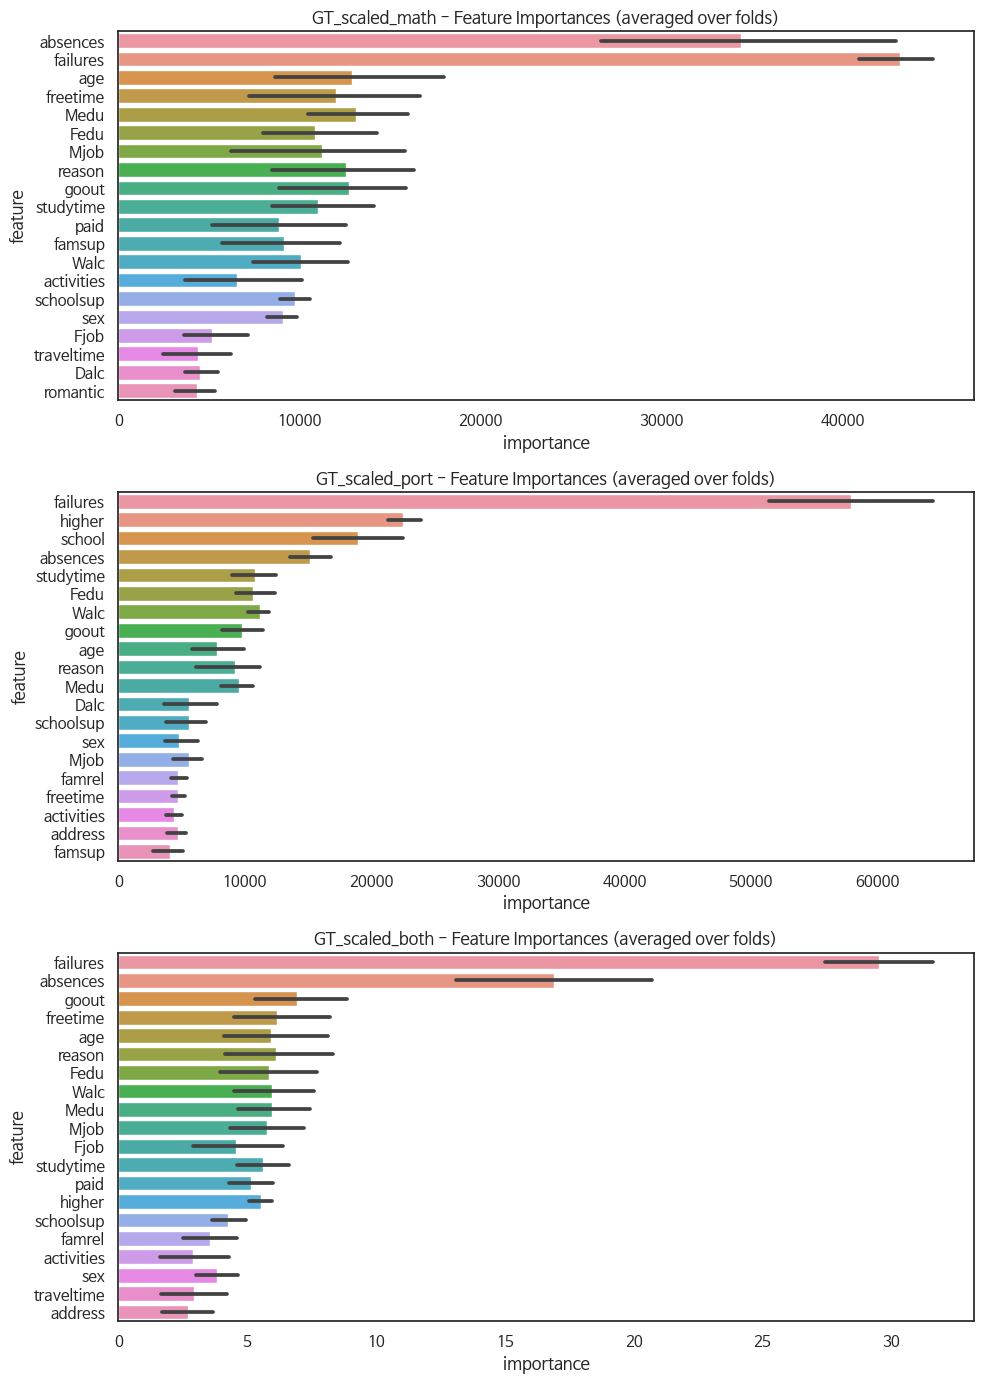

In [367]:
plt.figure(figsize=(10,14))

plt.subplot(3,1,1)
cols = (fi_df_math[['feature', 'importance']]
        .groupby('feature')
        .mean()
        .sort_values(by='importance', ascending=False)[:20].index)
best_features = fi_df_math.loc[fi_df_math.feature.isin(cols)]

sns.barplot(x='importance', y='feature', data=best_features.sort_values(by='importance', ascending=False))
plt.title('GT_scaled_math - Feature Importances (averaged over folds)')

plt.subplot(3,1,2)
cols = (fi_df_port[['feature', 'importance']]
        .groupby('feature')
        .mean()
        .sort_values(by='importance', ascending=False)[:20].index)
best_features = fi_df_port.loc[fi_df_math.feature.isin(cols)]

sns.barplot(x='importance', y='feature', data=best_features.sort_values(by='importance', ascending=False))
plt.title('GT_scaled_port - Feature Importances (averaged over folds)')

plt.subplot(3,1,3)
cols = (fi_df_both[['feature', 'importance']]
        .groupby('feature')
        .mean()
        .sort_values(by='importance', ascending=False)[:20].index)
best_features = fi_df_both.loc[fi_df_both.feature.isin(cols)]

sns.barplot(x='importance', y='feature', data=best_features.sort_values(by='importance', ascending=False))
plt.title('GT_scaled_both - Feature Importances (averaged over folds)')
plt.tight_layout()

* 수학 과목은 결석을 하면 수업내용을 따라가기 힘들어 결석이 성적을 결정하는데 중요한 역할을 미치는 것으로 보입니다.
* 낙제 횟수는 성적과 연관이 커 수학, 국어 모두 높은 연관관계를 보입니다.
<br></br>
* 낙제와 결석을 제외한 뒤 다시 중요도를 검사합니다.

In [368]:
## 낙제와 결석을 제외한 Feature Importance
X_math = math[['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'schoolsup',
       'famsup', 'paid', 'activities', 'nursery','Walc',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc']]
       

X_port = port[['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'schoolsup',
       'famsup', 'paid', 'activities', 'nursery','Walc',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc']]
       
X_both = both[['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'schoolsup',
       'famsup', 'paid', 'activities', 'nursery','Walc',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc']]

cat_cols = X_math.select_dtypes('object').columns
for col in cat_cols:
    le = LabelEncoder()
    X_math[col] = le.fit_transform(X_math[col])
    
cat_cols = X_port.select_dtypes('object').columns
for col in cat_cols:
    le = LabelEncoder()
    X_port[col] = le.fit_transform(X_port[col])
    
cat_cols = X_both.select_dtypes('object').columns
for col in cat_cols:
    le = LabelEncoder()
    X_both[col] = le.fit_transform(X_both[col])
    
fi_df_math = get_FI_lgb(X_math, y_math, lgb_param)
fi_df_port = get_FI_lgb(X_port, y_port, lgb_param)
fi_df_both = get_FI_lgb(X_both, y_both, lgb_param)

CV-Score: 5857252289929909993734144.000000
CV-Score: 4626321421649801069461504.000000
CV-Score: 0.274587


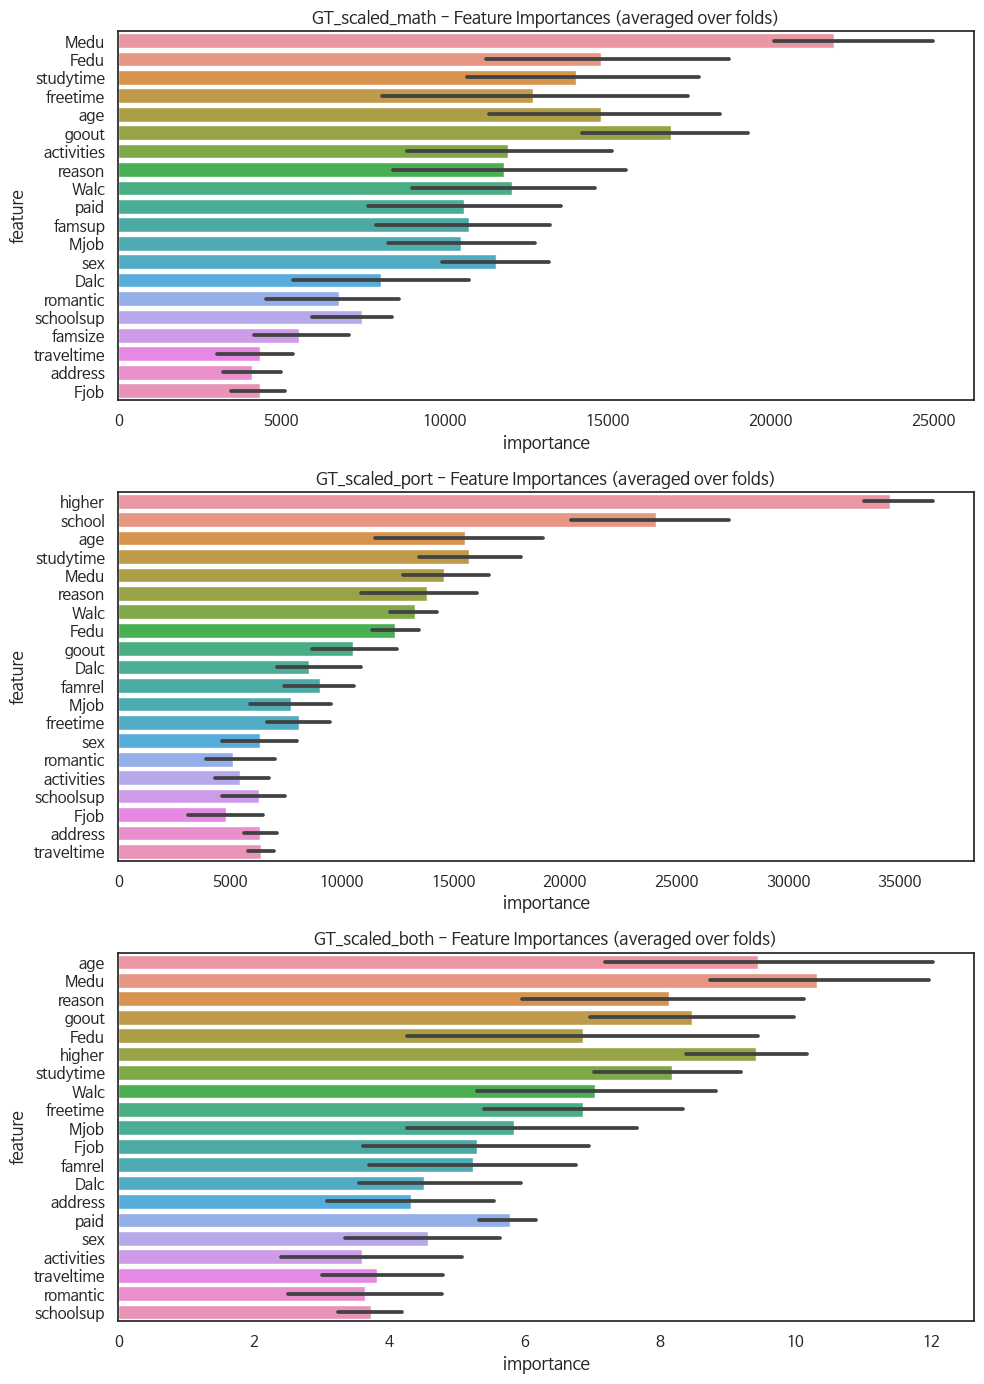

In [369]:
plt.figure(figsize=(10,14))

plt.subplot(3,1,1)
cols = (fi_df_math[['feature', 'importance']]
        .groupby('feature')
        .mean()
        .sort_values(by='importance', ascending=False)[:20].index)
best_features = fi_df_math.loc[fi_df_math.feature.isin(cols)]

sns.barplot(x='importance', y='feature', data=best_features.sort_values(by='importance', ascending=False))
plt.title('GT_scaled_math - Feature Importances (averaged over folds)')

plt.subplot(3,1,2)
cols = (fi_df_port[['feature', 'importance']]
        .groupby('feature')
        .mean()
        .sort_values(by='importance', ascending=False)[:20].index)
best_features = fi_df_port.loc[fi_df_math.feature.isin(cols)]

sns.barplot(x='importance', y='feature', data=best_features.sort_values(by='importance', ascending=False))
plt.title('GT_scaled_port - Feature Importances (averaged over folds)')

plt.subplot(3,1,3)
cols = (fi_df_both[['feature', 'importance']]
        .groupby('feature')
        .mean()
        .sort_values(by='importance', ascending=False)[:20].index)
best_features = fi_df_both.loc[fi_df_both.feature.isin(cols)]

sns.barplot(x='importance', y='feature', data=best_features.sort_values(by='importance', ascending=False))
plt.title('GT_scaled_both - Feature Importances (averaged over folds)')
plt.tight_layout()

## 부모님의 직업별 성적 분포

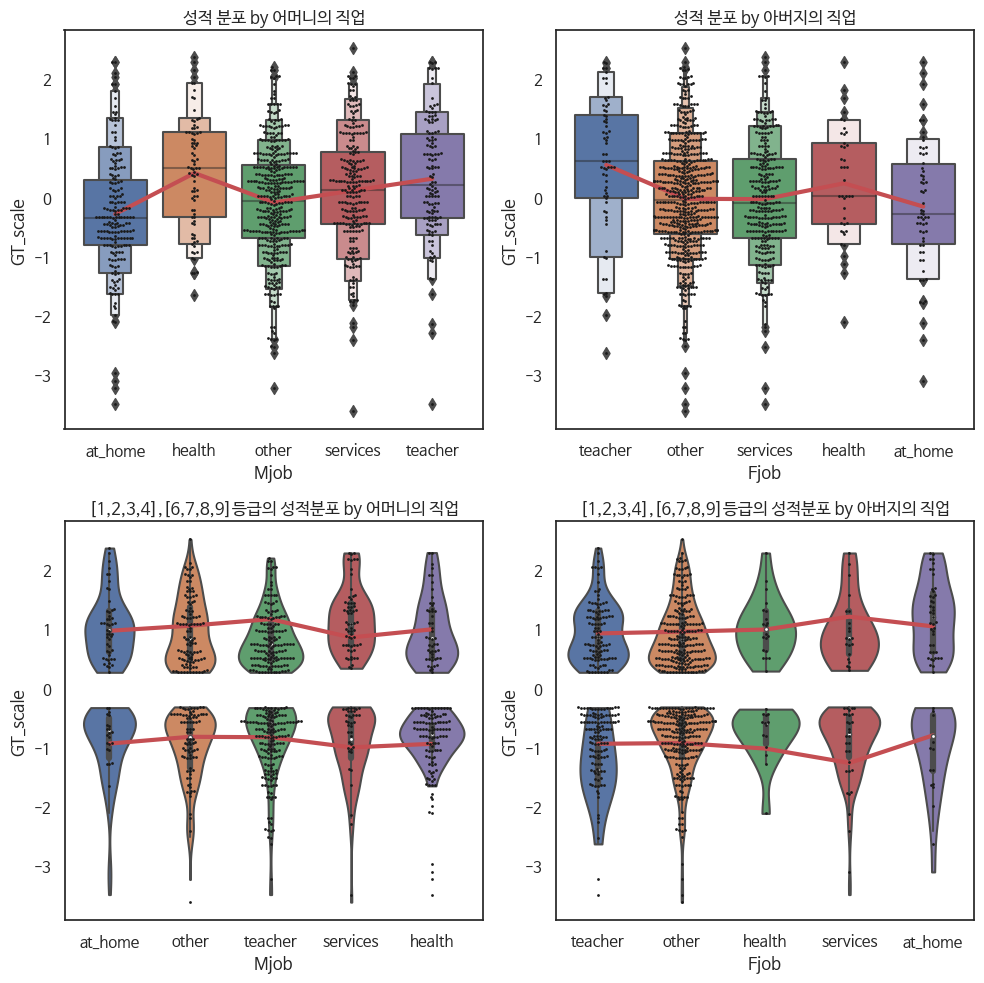

In [41]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
sns.boxenplot(data=both, x="Mjob", y="GT_scale")
sns.swarmplot(data=both, x="Mjob", y="GT_scale", size=2, color="0.1")
plt.plot([0, 1, 2, 3, 4],[
             both[both["Mjob"]=="at_home"]["GT_scale"].values.mean(),
             both[both["Mjob"]=="health"]["GT_scale"].values.mean(),
             both[both["Mjob"]=="other"]["GT_scale"].values.mean(),
             both[both["Mjob"]=="services"]["GT_scale"].values.mean(),
             both[both["Mjob"]=="teacher"]["GT_scale"].values.mean(),],linewidth=3,color="r")
plt.title("성적 분포 by 어머니의 직업")

plt.subplot(2,2,2)
sns.boxenplot(data=both, x="Fjob", y="GT_scale")
sns.swarmplot(data=both, x="Fjob", y="GT_scale", size=2, color="0.1")
plt.plot([0, 1, 2, 3, 4],[
             both[both["Fjob"]=="teacher"]["GT_scale"].values.mean(),
             both[both["Fjob"]=="other"]["GT_scale"].values.mean(),
             both[both["Fjob"]=="services"]["GT_scale"].values.mean(),
             both[both["Fjob"]=="health"]["GT_scale"].values.mean(),
             both[both["Fjob"]=="at_home"]["GT_scale"].values.mean(),],linewidth=3,color="r")
plt.title("성적 분포 by 아버지의 직업")



plt.subplot(2,2,3)
df = both[both["GT_scale_rank_bin"]<=4]
sns.violinplot(data=df, x="Mjob", y="GT_scale",cut=0)
sns.swarmplot(data=df, x="Mjob", y="GT_scale", size=2, color="0.1")

plt.plot([0, 1, 2, 3, 4],[
             df[df["Mjob"]=="services"]["GT_scale"].values.mean(),
             df[df["Mjob"]=="health"]["GT_scale"].values.mean(),
             df[df["Mjob"]=="teacher"]["GT_scale"].values.mean(),
             df[df["Mjob"]=="other"]["GT_scale"].values.mean(),
             df[df["Mjob"]=="at_home"]["GT_scale"].values.mean()],linewidth=3,color="r")

df = both[both["GT_scale_rank_bin"]>=6]
sns.violinplot(data=df, x="Mjob", y="GT_scale",cut=0)
sns.swarmplot(data=df, x="Mjob", y="GT_scale", size=2, color="0.1")
plt.plot([0, 1, 2, 3, 4],[
             df[df["Mjob"]=="services"]["GT_scale"].values.mean(),
             df[df["Mjob"]=="health"]["GT_scale"].values.mean(),
             df[df["Mjob"]=="teacher"]["GT_scale"].values.mean(),
             df[df["Mjob"]=="other"]["GT_scale"].values.mean(),
             df[df["Mjob"]=="at_home"]["GT_scale"].values.mean(),],linewidth=3,color="r")
plt.title("[1,2,3,4],[6,7,8,9]등급의 성적분포 by 어머니의 직업")

plt.subplot(2,2,4)

df = both[both["GT_scale_rank_bin"]<=4]
sns.violinplot(data=df, x="Fjob", y="GT_scale",cut=0)
sns.swarmplot(data=df, x="Fjob", y="GT_scale", size=2, color="0.1")
plt.plot([0, 1, 2, 3, 4],[
             df[df["Fjob"]=="other"]["GT_scale"].values.mean(),
             df[df["Fjob"]=="services"]["GT_scale"].values.mean(),
             df[df["Fjob"]=="at_home"]["GT_scale"].values.mean(),
             df[df["Fjob"]=="teacher"]["GT_scale"].values.mean(),
             df[df["Fjob"]=="health"]["GT_scale"].values.mean()],linewidth=3,color="r")


df = both[both["GT_scale_rank_bin"]>=6]
sns.violinplot(data=df, x="Fjob", y="GT_scale",cut=0)
sns.swarmplot(data=df, x="Fjob", y="GT_scale", size=2, color="0.1")
plt.plot([0, 1, 2, 3, 4],[
             df[df["Fjob"]=="other"]["GT_scale"].values.mean(),
             df[df["Fjob"]=="services"]["GT_scale"].values.mean(),
             df[df["Fjob"]=="at_home"]["GT_scale"].values.mean(),
             df[df["Fjob"]=="teacher"]["GT_scale"].values.mean(),
             df[df["Fjob"]=="health"]["GT_scale"].values.mean(),],linewidth=3,color="r")
plt.title("[1,2,3,4],[6,7,8,9]등급의 성적분포 by 아버지의 직업")

plt.tight_layout()
plt.show()

## 부모님의 최종학력별 성적 분포

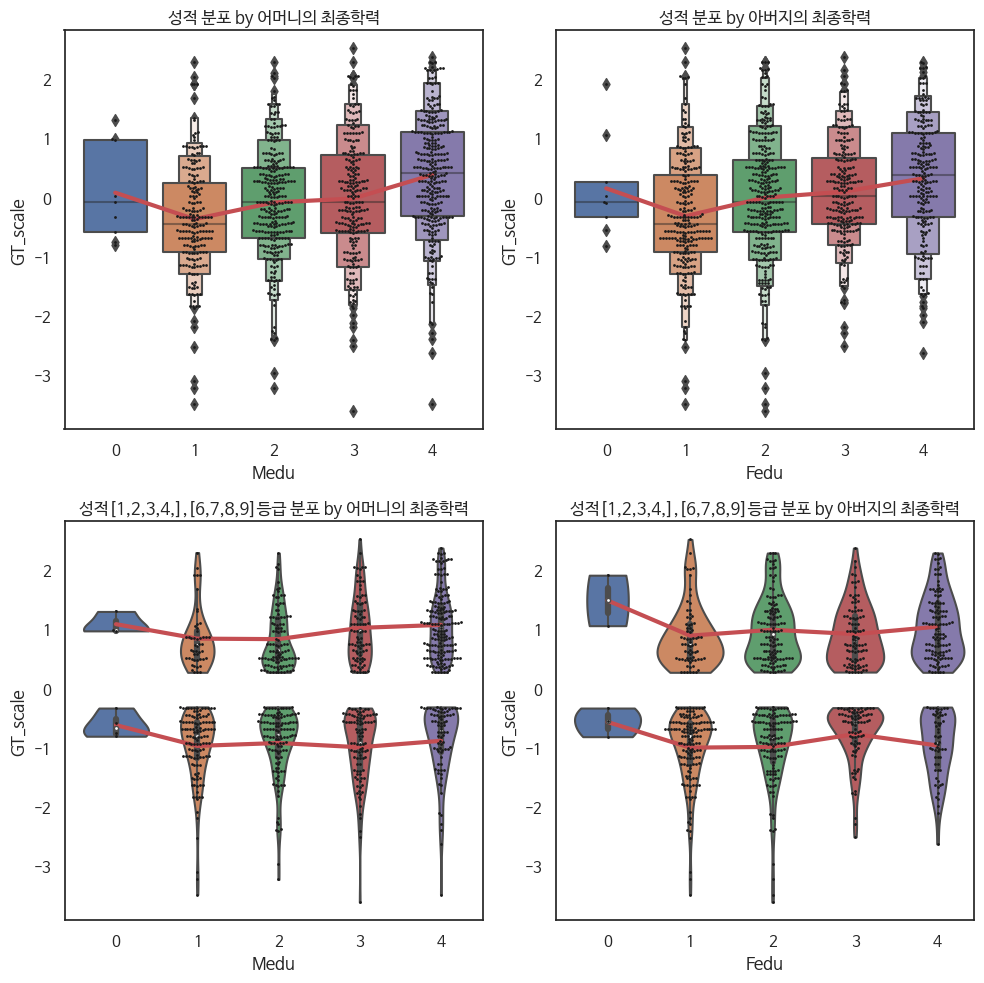

In [45]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
sns.boxenplot(data=both, x="Medu", y="GT_scale")
sns.swarmplot(data=both, x="Medu", y="GT_scale", size=2, color="0.1")
plt.plot([0, 1, 2, 3, 4],[
             both[both["Medu"]==0]["GT_scale"].values.mean(),
             both[both["Medu"]==1]["GT_scale"].values.mean(),
             both[both["Medu"]==2]["GT_scale"].values.mean(),
             both[both["Medu"]==3]["GT_scale"].values.mean(),
             both[both["Medu"]==4]["GT_scale"].values.mean(),],linewidth=3,color="r")
plt.title("성적 분포 by 어머니의 최종학력")

plt.subplot(2,2,2)
sns.boxenplot(data=both, x="Fedu", y="GT_scale")
sns.swarmplot(data=both, x="Fedu", y="GT_scale", size=2, color="0.1")
plt.plot([0, 1, 2, 3, 4],[
             both[both["Fedu"]==0]["GT_scale"].values.mean(),
             both[both["Fedu"]==1]["GT_scale"].values.mean(),
             both[both["Fedu"]==2]["GT_scale"].values.mean(),
             both[both["Fedu"]==3]["GT_scale"].values.mean(),
             both[both["Fedu"]==4]["GT_scale"].values.mean(),],linewidth=3,color="r")
plt.title("성적 분포 by 아버지의 최종학력")


plt.subplot(2,2,3)

df_t = both[both["GT_scale_rank_bin"]<=4]
sns.violinplot(data=df_t, x="Medu", y="GT_scale",cut=0)
sns.swarmplot(data=df_t, x="Medu", y="GT_scale", size=2, color="0.1")

plt.plot([0, 1, 2, 3, 4],[
             df_t[df_t["Medu"]==0]["GT_scale"].values.mean(),
             df_t[df_t["Medu"]==1]["GT_scale"].values.mean(),
             df_t[df_t["Medu"]==2]["GT_scale"].values.mean(),
             df_t[df_t["Medu"]==3]["GT_scale"].values.mean(),
             df_t[df_t["Medu"]==4]["GT_scale"].values.mean()],linewidth=3,color="r")

df_t = both[both["GT_scale_rank_bin"]>=6]
sns.violinplot(data=df_t, x="Medu", y="GT_scale",cut=0)
sns.swarmplot(data=df_t, x="Medu", y="GT_scale", size=2, color="0.1")
plt.plot([0, 1, 2, 3, 4],[
             df_t[df_t["Medu"]==0]["GT_scale"].values.mean(),
             df_t[df_t["Medu"]==1]["GT_scale"].values.mean(),
             df_t[df_t["Medu"]==2]["GT_scale"].values.mean(),
             df_t[df_t["Medu"]==3]["GT_scale"].values.mean(),
             df_t[df_t["Medu"]==4]["GT_scale"].values.mean(),],linewidth=3,color="r")

plt.title("성적[1,2,3,4,],[6,7,8,9]등급 분포 by 어머니의 최종학력")

plt.subplot(2,2,4)

df_t = both[both["GT_scale_rank_bin"]<=4]
sns.violinplot(data=df_t, x="Fedu", y="GT_scale",cut=0)
sns.swarmplot(data=df_t, x="Fedu", y="GT_scale", size=2, color="0.1")
plt.plot([0, 1, 2, 3, 4],[
             df_t[df_t["Fedu"]==0]["GT_scale"].values.mean(),
             df_t[df_t["Fedu"]==1]["GT_scale"].values.mean(),
             df_t[df_t["Fedu"]==2]["GT_scale"].values.mean(),
             df_t[df_t["Fedu"]==3]["GT_scale"].values.mean(),
             df_t[df_t["Fedu"]==4]["GT_scale"].values.mean()],linewidth=3,color="r")

df_t = both[both["GT_scale_rank_bin"]>=6]
sns.violinplot(data=df_t, x="Fedu", y="GT_scale",cut=0)
sns.swarmplot(data=df_t, x="Fedu", y="GT_scale", size=2, color="0.1")
plt.plot([0, 1, 2, 3, 4],[
             df_t[df_t["Fedu"]==0]["GT_scale"].values.mean(),
             df_t[df_t["Fedu"]==1]["GT_scale"].values.mean(),
             df_t[df_t["Fedu"]==2]["GT_scale"].values.mean(),
             df_t[df_t["Fedu"]==3]["GT_scale"].values.mean(),
             df_t[df_t["Fedu"]==4]["GT_scale"].values.mean(),],linewidth=3,color="r")

plt.title("성적[1,2,3,4,],[6,7,8,9]등급 분포 by 아버지의 최종학력")

plt.tight_layout()
plt.show()

## 공부시간, 휴식시간별 수학 성적 분포

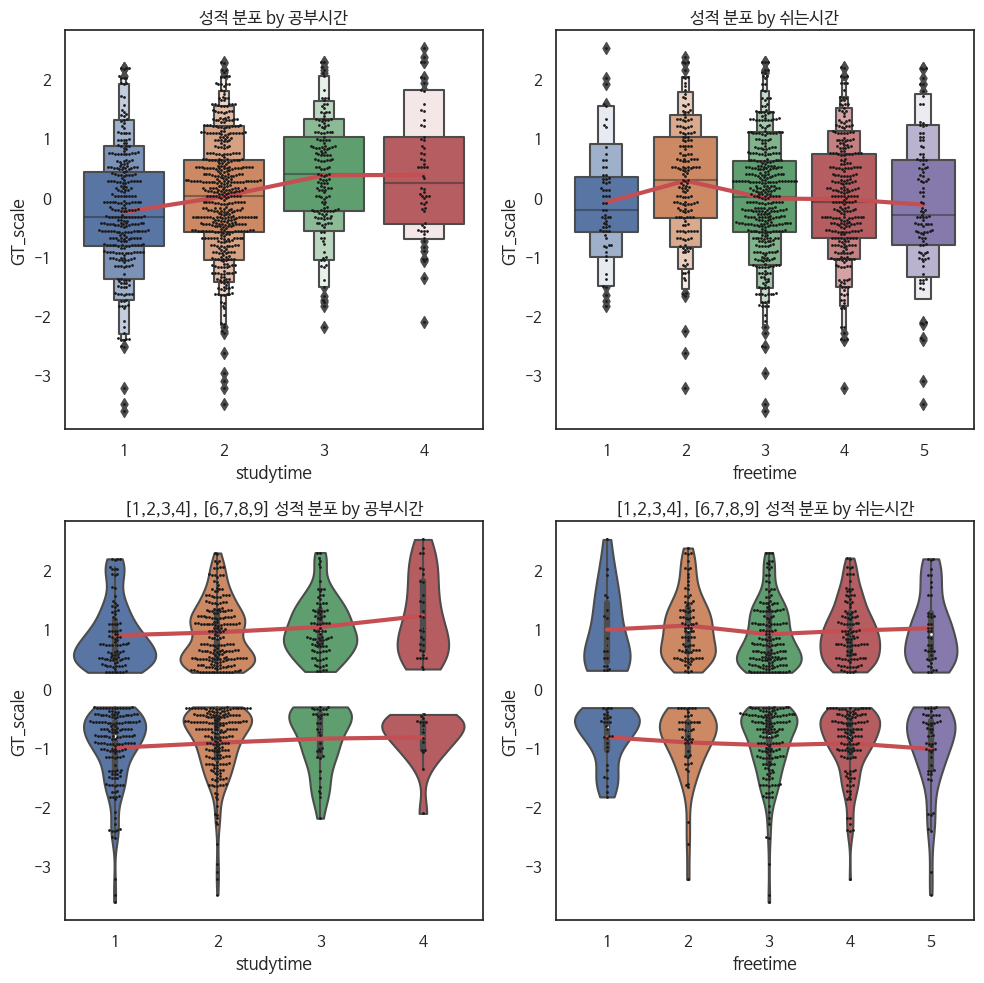

In [39]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
sns.boxenplot(data=both, x="studytime", y="GT_scale")
sns.swarmplot(data=both, x="studytime", y="GT_scale", size=2, color="0.1")
plt.plot([0, 1, 2, 3],[
             both[both["studytime"]==1]["GT_scale"].values.mean(),
             both[both["studytime"]==2]["GT_scale"].values.mean(),
             both[both["studytime"]==3]["GT_scale"].values.mean(),
             both[both["studytime"]==4]["GT_scale"].values.mean()],linewidth=3,color="r")
plt.title("성적 분포 by 공부시간")

plt.subplot(2,2,2)
sns.boxenplot(data=both, x="freetime", y="GT_scale")
sns.swarmplot(data=both, x="freetime", y="GT_scale", size=2, color="0.1")
plt.plot([0, 1, 2, 3, 4],[
             both[both["freetime"]==1]["GT_scale"].values.mean(),
             both[both["freetime"]==2]["GT_scale"].values.mean(),
             both[both["freetime"]==3]["GT_scale"].values.mean(),
             both[both["freetime"]==4]["GT_scale"].values.mean(),
             both[both["freetime"]==5]["GT_scale"].values.mean(),],linewidth=3,color="r")
plt.title("성적 분포 by 쉬는시간")



plt.subplot(2,2,3)
df = both[both["GT_scale_rank_bin"]<=4]
sns.violinplot(data=df, x="studytime", y="GT_scale",cut=0)
sns.swarmplot(data=df, x="studytime", y="GT_scale", size=2, color="0.1")

plt.plot([0, 1, 2, 3],[
             df[df["studytime"]==1]["GT_scale"].values.mean(),
             df[df["studytime"]==2]["GT_scale"].values.mean(),
             df[df["studytime"]==3]["GT_scale"].values.mean(),
             df[df["studytime"]==4]["GT_scale"].values.mean(),],linewidth=3,color="r")

df = both[both["GT_scale_rank_bin"]>=6]

sns.violinplot(data=df, x="studytime", y="GT_scale",cut=0)
sns.swarmplot(data=df, x="studytime", y="GT_scale", size=2, color="0.1")

plt.plot([0, 1, 2, 3],[
             df[df["studytime"]==1]["GT_scale"].values.mean(),
             df[df["studytime"]==2]["GT_scale"].values.mean(),
             df[df["studytime"]==3]["GT_scale"].values.mean(),
             df[df["studytime"]==4]["GT_scale"].values.mean(),],linewidth=3,color="r")
plt.title("[1,2,3,4], [6,7,8,9] 성적 분포 by 공부시간")

plt.subplot(2,2,4)
df = both[both["GT_scale_rank_bin"]<=4]
sns.violinplot(data=df, x="freetime", y="GT_scale",cut=0)
sns.swarmplot(data=df, x="freetime", y="GT_scale", size=2, color="0.1")

plt.plot([0, 1, 2, 3, 4],[
             df[df["freetime"]==1]["GT_scale"].values.mean(),
             df[df["freetime"]==2]["GT_scale"].values.mean(),
             df[df["freetime"]==3]["GT_scale"].values.mean(),
             df[df["freetime"]==4]["GT_scale"].values.mean(),
             df[df["freetime"]==5]["GT_scale"].values.mean(),],linewidth=3,color="r")

df = both[both["GT_scale_rank_bin"]>=6]

sns.violinplot(data=df, x="freetime", y="GT_scale",cut=0)
sns.swarmplot(data=df, x="freetime", y="GT_scale", size=2, color="0.1")

plt.plot([0, 1, 2, 3, 4],[
             df[df["freetime"]==1]["GT_scale"].values.mean(),
             df[df["freetime"]==2]["GT_scale"].values.mean(),
             df[df["freetime"]==3]["GT_scale"].values.mean(),
             df[df["freetime"]==4]["GT_scale"].values.mean(),
             df[df["freetime"]==5]["GT_scale"].values.mean(),],linewidth=3,color="r")
plt.title("[1,2,3,4], [6,7,8,9] 성적 분포 by 쉬는시간")

plt.tight_layout()
plt.show()

## 나이, 놀러나가는 횟수 - 성적의 관계

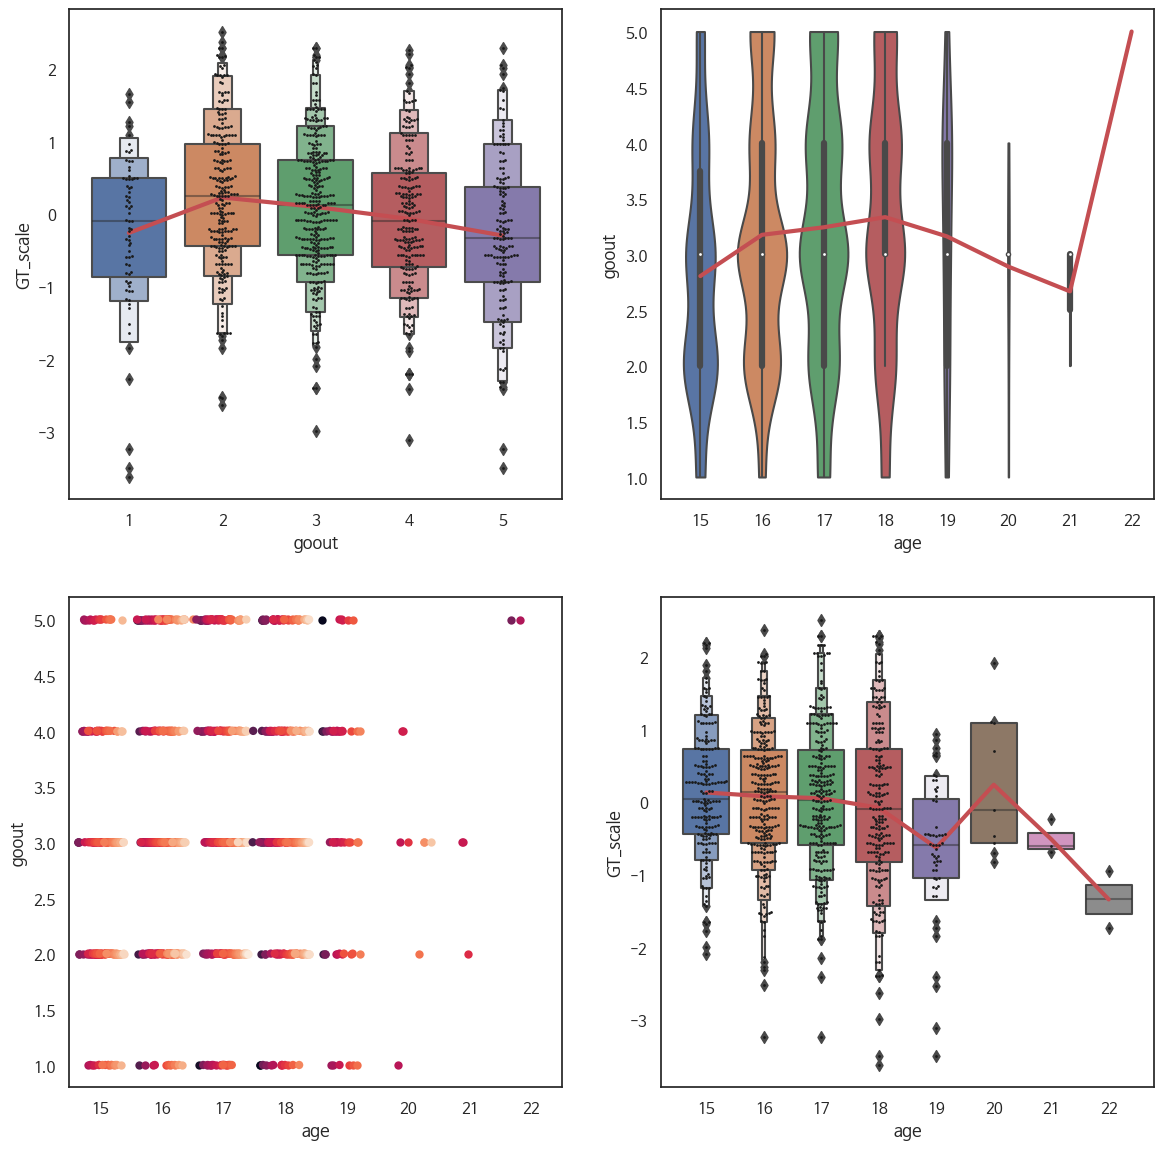

In [17]:
plt.figure(figsize=(14,14))
plt.subplot(2,2,1)
sns.boxenplot(data=both, x="goout", y="GT_scale")
sns.swarmplot(data=both, x="goout", y="GT_scale", size=2, color="0.1")
plt.plot([0, 1, 2, 3, 4],[
             both[both["goout"]==1]["GT_scale"].values.mean(),
             both[both["goout"]==2]["GT_scale"].values.mean(),
             both[both["goout"]==3]["GT_scale"].values.mean(),
             both[both["goout"]==4]["GT_scale"].values.mean(),
             both[both["goout"]==5]["GT_scale"].values.mean(),],linewidth=3,color="r")



plt.subplot(2,2,2)
sns.violinplot(data=both, x="age", y="goout",cut=0,scale="count")
plt.plot([0, 1, 2, 3, 4, 5, 6, 7],[
             both[both["age"]==15]["goout"].values.mean(),
             both[both["age"]==16]["goout"].values.mean(),
             both[both["age"]==17]["goout"].values.mean(),
             both[both["age"]==18]["goout"].values.mean(),
             both[both["age"]==19]["goout"].values.mean(),
             both[both["age"]==20]["goout"].values.mean(),    
             both[both["age"]==21]["goout"].values.mean(),
             both[both["age"]==22]["goout"].values.mean(),],linewidth=3,color="r")

plt.subplot(2,2,3)
sns.swarmplot(data=both, x="age", y="goout",hue="GT_scale",dodge=True,palette="rocket",size=6,legend=False)

plt.subplot(2,2,4)
sns.boxenplot(data=both, x="age", y="GT_scale")
sns.swarmplot(data=both, x="age", y="GT_scale", size=2, color="0.1")
plt.plot([0, 1, 2, 3, 4, 5, 6, 7],[
             both[both["age"]==15]["GT_scale"].values.mean(),
             both[both["age"]==16]["GT_scale"].values.mean(),
             both[both["age"]==17]["GT_scale"].values.mean(),
             both[both["age"]==18]["GT_scale"].values.mean(),
             both[both["age"]==19]["GT_scale"].values.mean(),
             both[both["age"]==20]["GT_scale"].values.mean(),    
             both[both["age"]==21]["GT_scale"].values.mean(),
             both[both["age"]==22]["GT_scale"].values.mean(),],linewidth=3,color="r")

## 가정환경[보육원, 가족크기, 부모님과의 동거, 보호자] 에 따른 성적분포

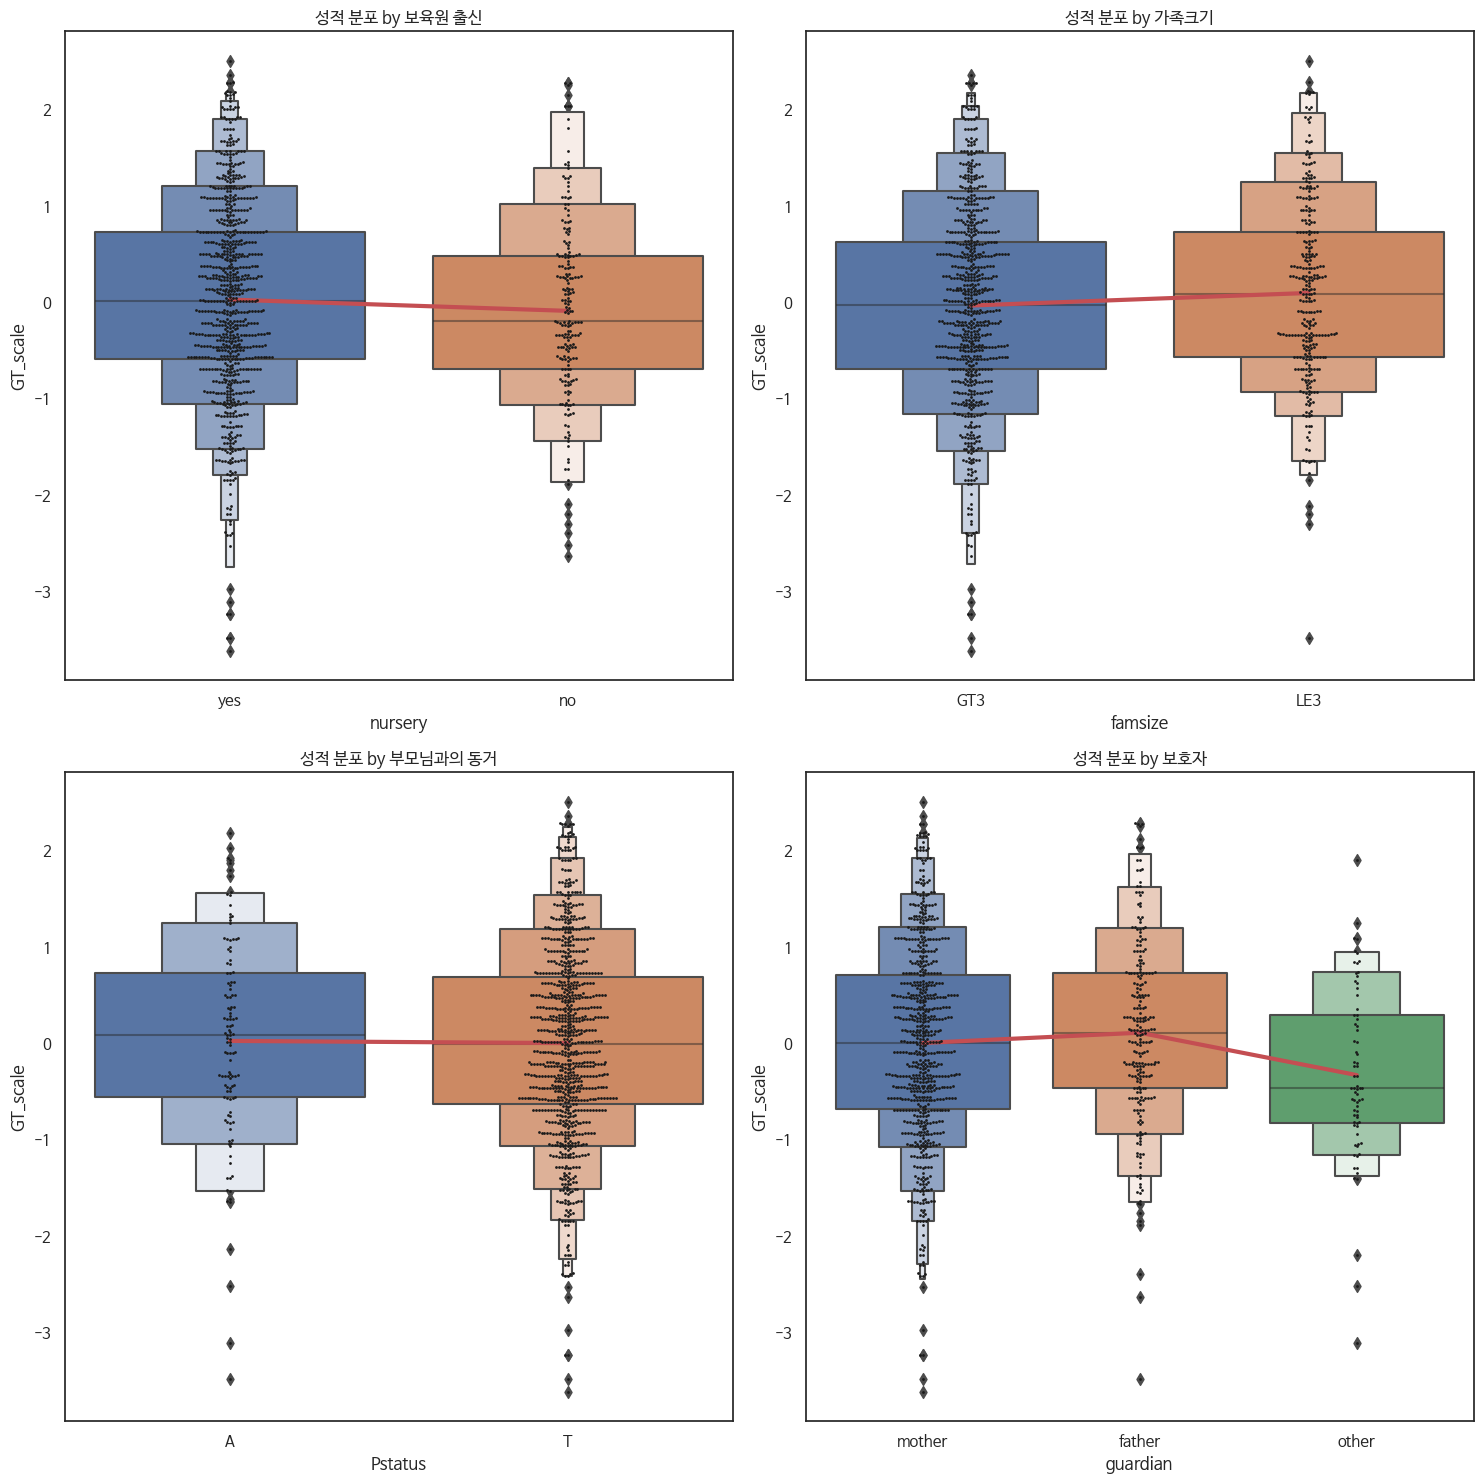

In [426]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
sns.boxenplot(data=both, x="nursery", y="GT_scale")
sns.swarmplot(data=both, x="nursery", y="GT_scale", size=2, color="0.1")
plt.plot([0, 1], [both[both["nursery"]=="yes"]["GT_scale"].values.mean(), both[both["nursery"]=="no"]["GT_scale"].values.mean()], linewidth=3,color="r")
plt.title("성적 분포 by 보육원 출신")

plt.subplot(2,2,2)
sns.boxenplot(data=both, x="famsize", y="GT_scale")
sns.swarmplot(data=both, x="famsize", y="GT_scale", size=2, color="0.1")
plt.plot([0, 1], [both[both["famsize"]=="GT3"]["GT_scale"].values.mean(), both[both["famsize"]=="LE3"]["GT_scale"].values.mean()], linewidth=3,color="r")
plt.title("성적 분포 by 가족크기")

plt.subplot(2,2,3)
sns.boxenplot(data=both, x="Pstatus", y="GT_scale")
sns.swarmplot(data=both, x="Pstatus", y="GT_scale", size=2, color="0.1")
plt.plot(
    [0, 1], [both[both["Pstatus"]=="A"]["GT_scale"].values.mean(), both[both["Pstatus"]=="T"]["GT_scale"].values.mean()],
    linewidth=3,color="r")
plt.title("성적 분포 by 부모님과의 동거")

plt.subplot(2,2,4)
sns.boxenplot(data=both, x="guardian", y="GT_scale")
sns.swarmplot(data=both, x="guardian", y="GT_scale", size=2, color="0.1")
plt.plot(
    [0, 1, 2],
    [both[both["guardian"]=="mother"]["GT_scale"].values.mean(), both[both["guardian"]=="father"]["GT_scale"].values.mean(),both[both["guardian"]=="other"]["GT_scale"].values.mean()],
    linewidth=3,color="r")
plt.title("성적 분포 by 보호자")

plt.tight_layout()
plt.show()

## 공부환경[학교의 지원, 부모의지원 ,사교육, 방과 후 활동]

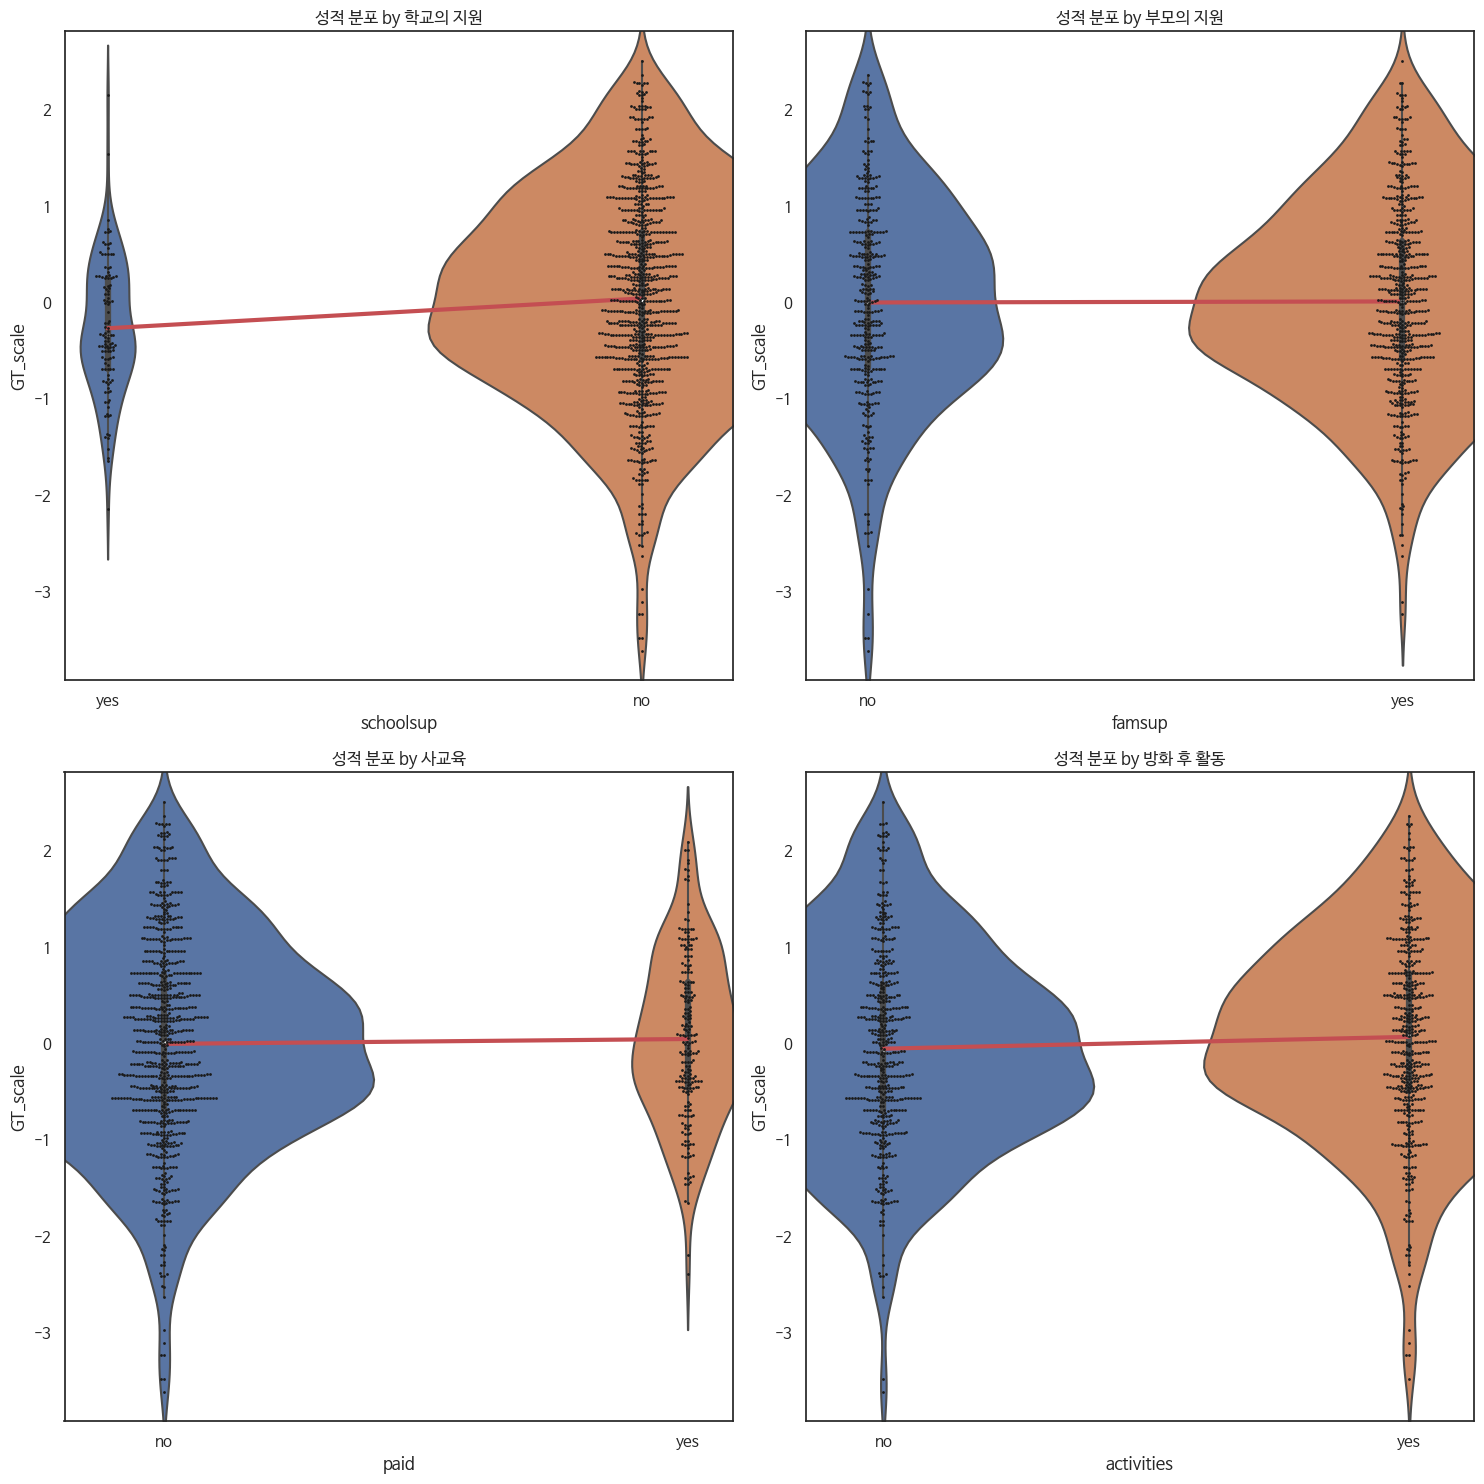

In [438]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
sns.violinplot(data=both, x="schoolsup", y="GT_scale",scale="count")
sns.swarmplot(data=both, x="schoolsup", y="GT_scale", size=2, color="0.1")
plt.plot([0, 1], [both[both["schoolsup"]=="yes"]["GT_scale"].values.mean(), both[both["schoolsup"]=="no"]["GT_scale"].values.mean()], linewidth=3,color="r")
plt.title("성적 분포 by 학교의 지원")

plt.subplot(2,2,2)
sns.violinplot(data=both, x="famsup", y="GT_scale",scale="count")
sns.swarmplot(data=both, x="famsup", y="GT_scale", size=2, color="0.1")
plt.plot([0, 1], [both[both["famsup"]=="no"]["GT_scale"].values.mean(), both[both["famsup"]=="yes"]["GT_scale"].values.mean()], linewidth=3,color="r")
plt.title("성적 분포 by 부모의 지원")

plt.subplot(2,2,3)
sns.violinplot(data=both, x="paid", y="GT_scale",scale="count")
sns.swarmplot(data=both, x="paid", y="GT_scale", size=2, color="0.1")
plt.plot(
    [0, 1], [both[both["paid"]=="no"]["GT_scale"].values.mean(), both[both["paid"]=="yes"]["GT_scale"].values.mean()],
    linewidth=3,color="r")
plt.title("성적 분포 by 사교육")

plt.subplot(2,2,4)
sns.violinplot(data=both, x="activities", y="GT_scale",scale="count")
sns.swarmplot(data=both, x="activities", y="GT_scale", size=2, color="0.1")
plt.plot(
    [0, 1],
    [both[both["activities"]=="no"]["GT_scale"].values.mean(), both[both["activities"]=="yes"]["GT_scale"].values.mean()],
    linewidth=3,color="r")
plt.title("성적 분포 by 방화 후 활동")

plt.tight_layout()
plt.show()

## 멘탈관리[목표의식, 인터넷, 연애, 가족들의 관계]

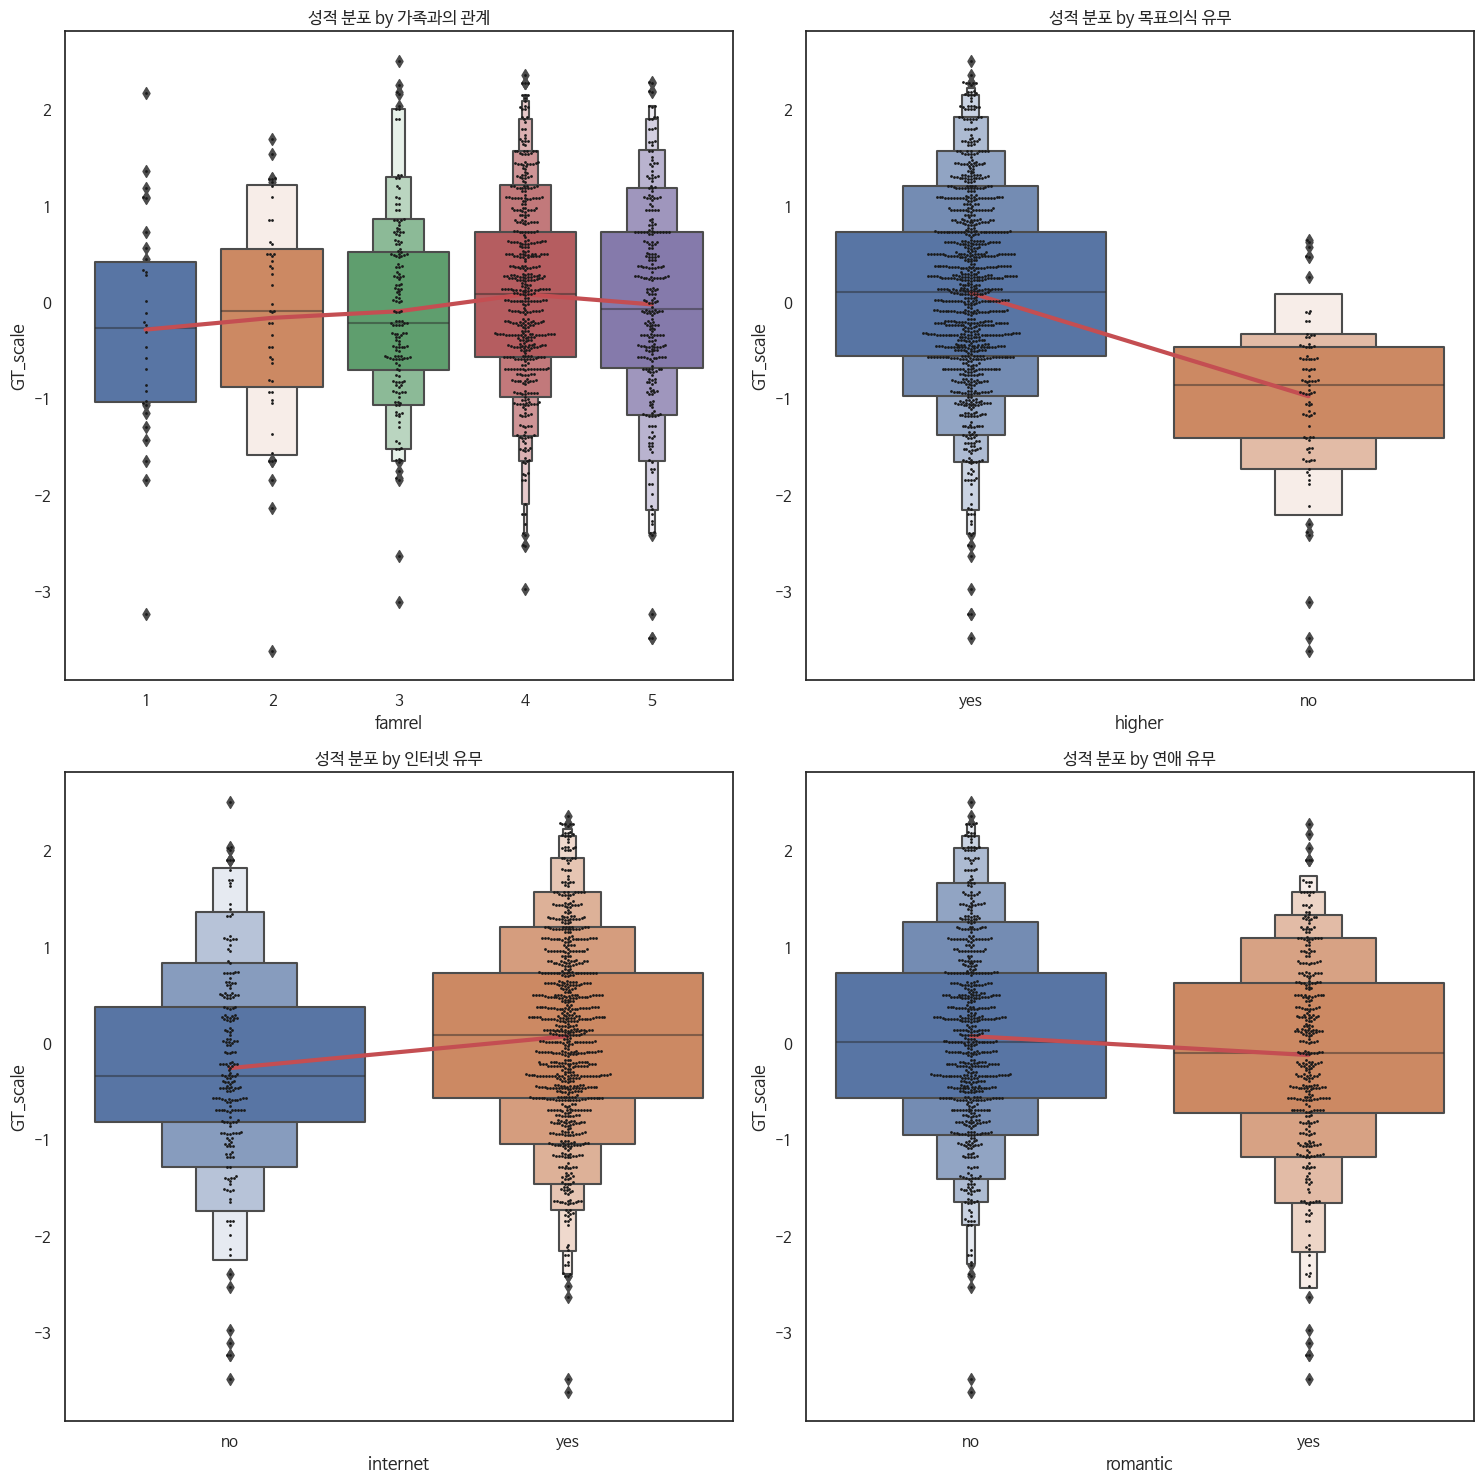

In [437]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
sns.boxenplot(data=both, x="famrel", y="GT_scale")
sns.swarmplot(data=both, x="famrel", y="GT_scale", size=2, color="0.1")
plt.plot([0, 1, 2, 3, 4],[
             both[both["famrel"]==1]["GT_scale"].values.mean(),
             both[both["famrel"]==2]["GT_scale"].values.mean(),
             both[both["famrel"]==3]["GT_scale"].values.mean(),
             both[both["famrel"]==4]["GT_scale"].values.mean(),
             both[both["famrel"]==5]["GT_scale"].values.mean(),],linewidth=3,color="r")
plt.title("성적 분포 by 가족과의 관계")

plt.subplot(2,2,2)
sns.boxenplot(data=both, x="higher", y="GT_scale")
sns.swarmplot(data=both, x="higher", y="GT_scale", size=2, color="0.1")
plt.plot([0, 1], [both[both["higher"]=="yes"]["GT_scale"].values.mean(), both[both["higher"]=="no"]["GT_scale"].values.mean()], linewidth=3,color="r")
plt.title("성적 분포 by 목표의식 유무")

plt.subplot(2,2,3)
sns.boxenplot(data=both, x="internet", y="GT_scale")
sns.swarmplot(data=both, x="internet", y="GT_scale", size=2, color="0.1")
plt.plot(
    [0, 1], [both[both["internet"]=="no"]["GT_scale"].values.mean(), both[both["internet"]=="yes"]["GT_scale"].values.mean()],
    linewidth=3,color="r")
plt.title("성적 분포 by 인터넷 유무")

plt.subplot(2,2,4)
sns.boxenplot(data=both, x="romantic", y="GT_scale")
sns.swarmplot(data=both, x="romantic", y="GT_scale", size=2, color="0.1")
plt.plot(
    [0, 1],
    [both[both["romantic"]=="no"]["GT_scale"].values.mean(), both[both["romantic"]=="yes"]["GT_scale"].values.mean()],
    linewidth=3,color="r")
plt.title("성적 분포 by 연애 유무")

plt.tight_layout()
plt.show()

In [81]:
bin_feature = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 
               'internet', 'romantic', 'school', 'sex', 'address', 'famsize', 'Pstatus']

nom_feature = ["Mjob","Fjob","reason","guardian"]

ord_feature = ['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']

num_feature = ['age', 'absences']

## 이진 피쳐의 전반적인 EDA

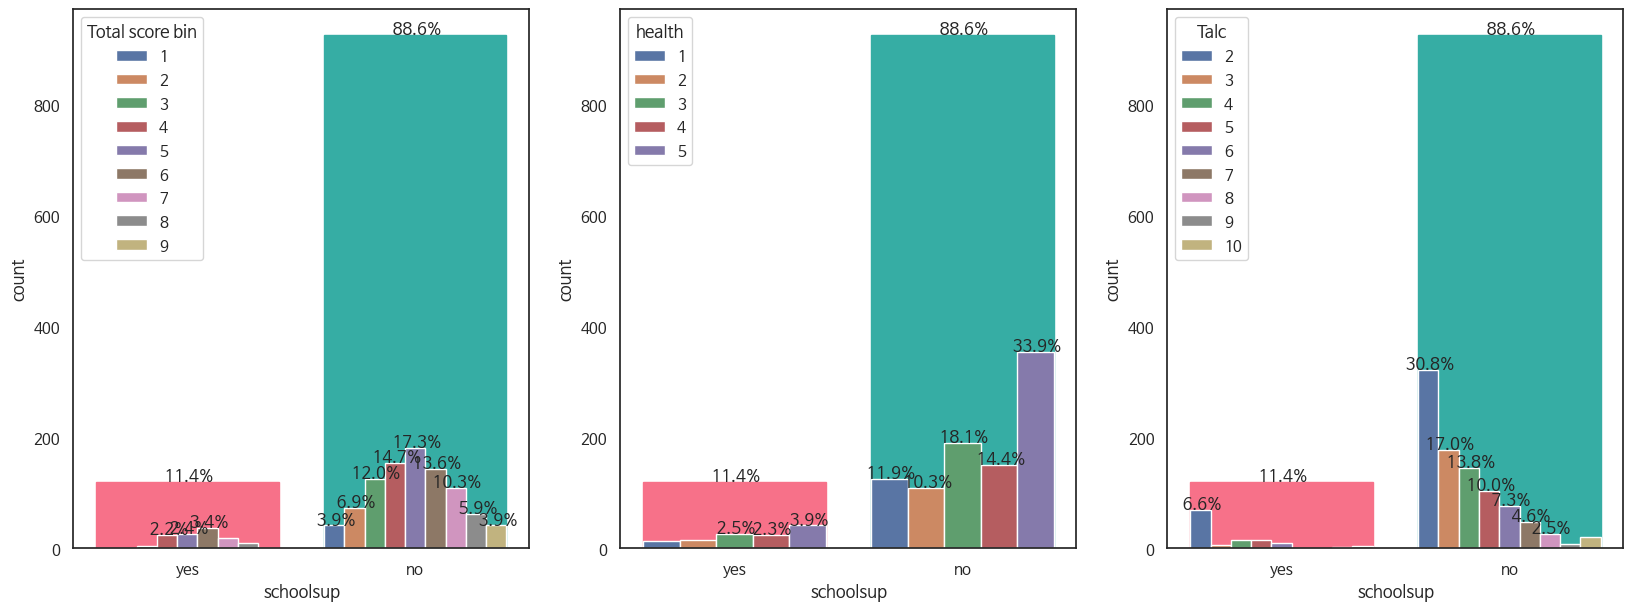

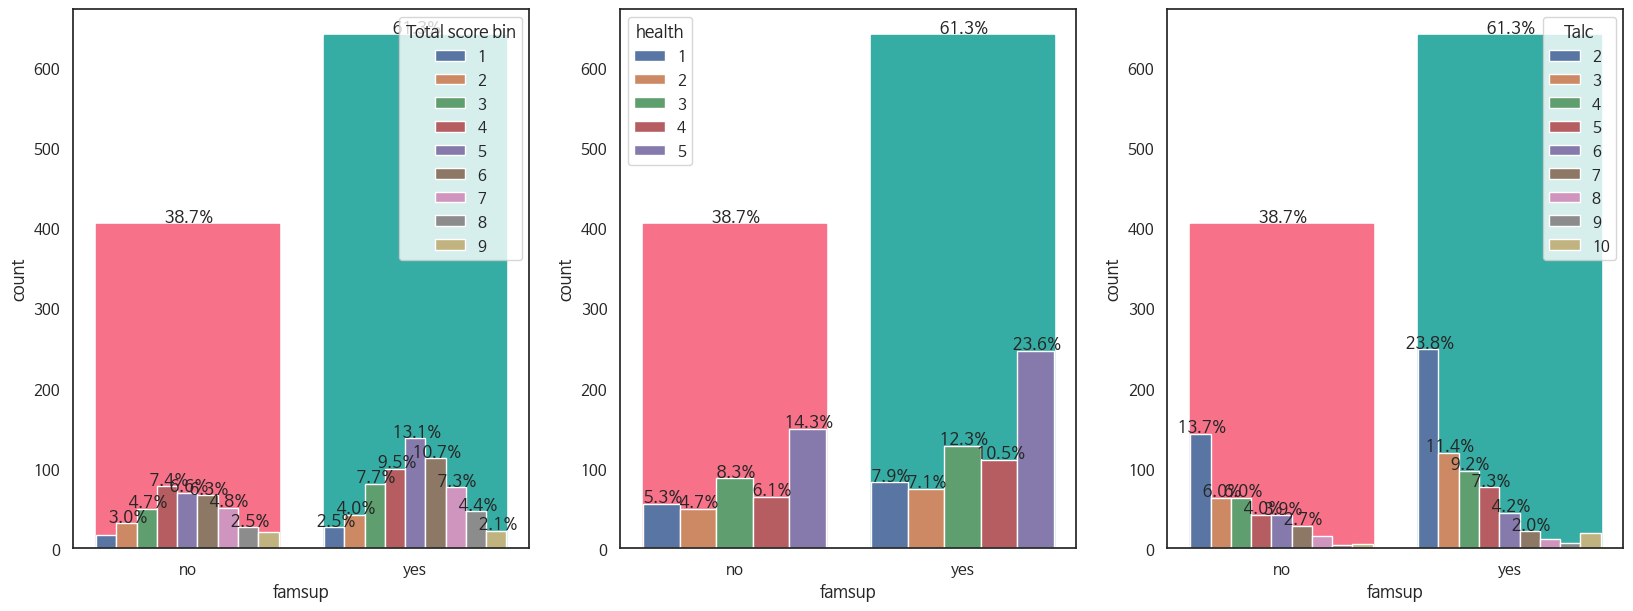

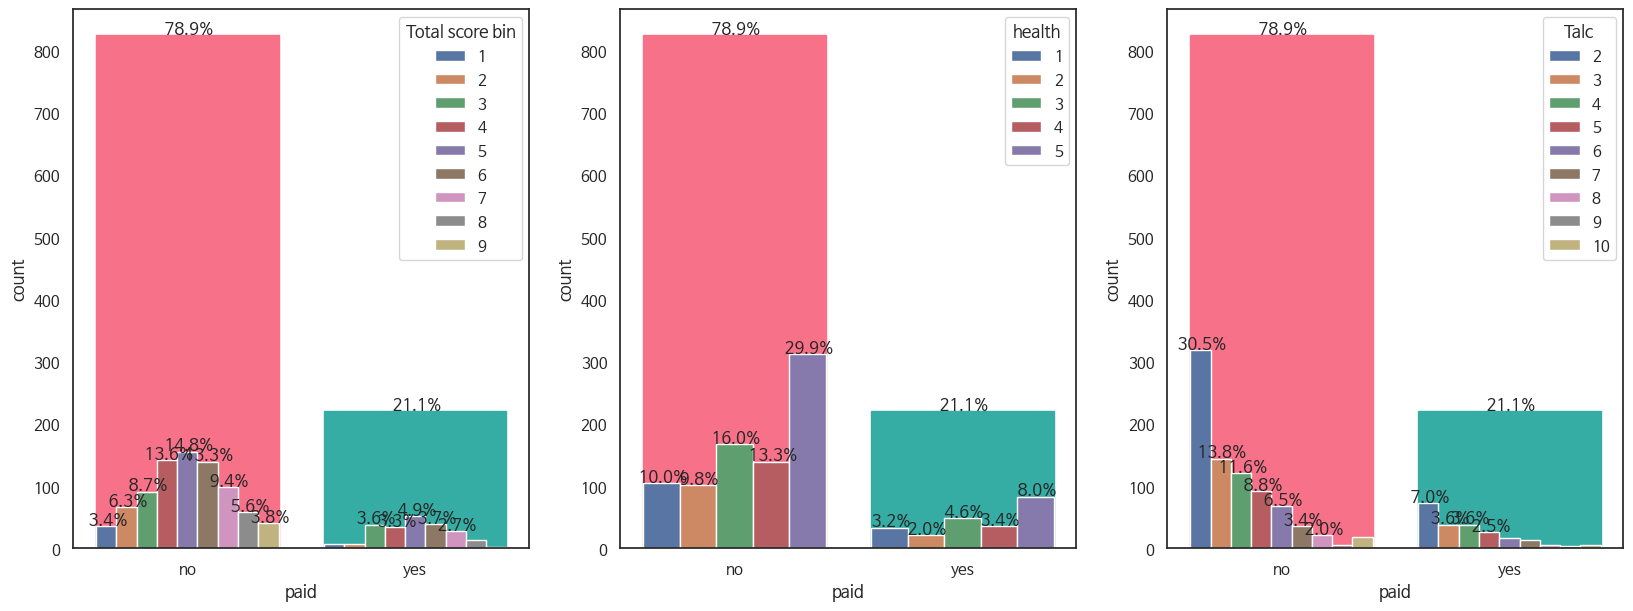

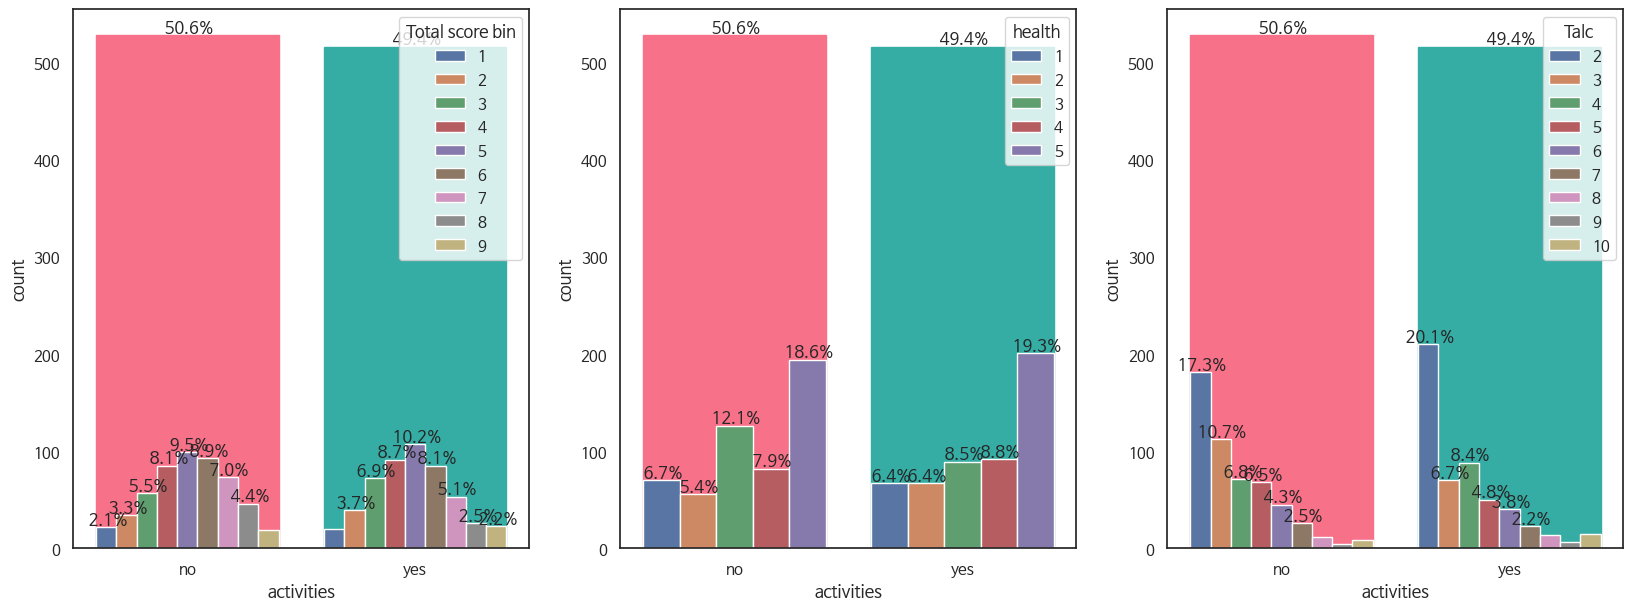

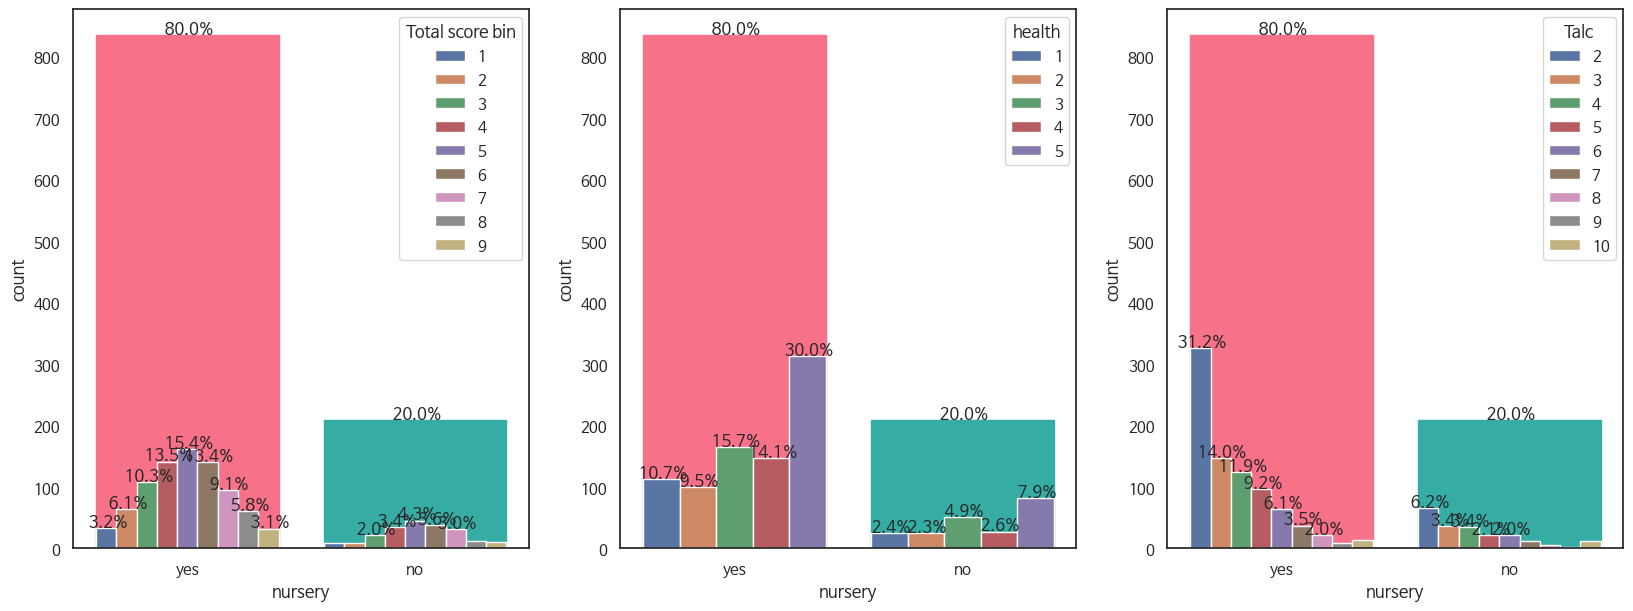

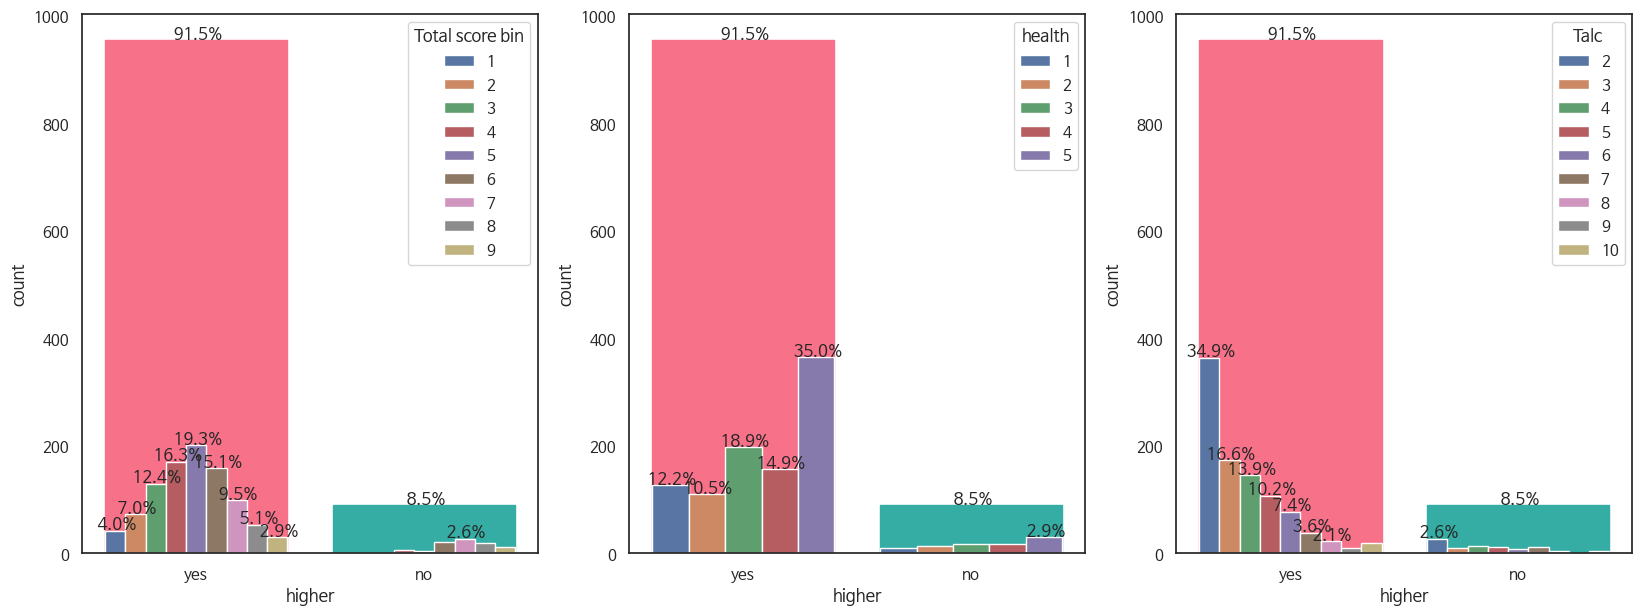

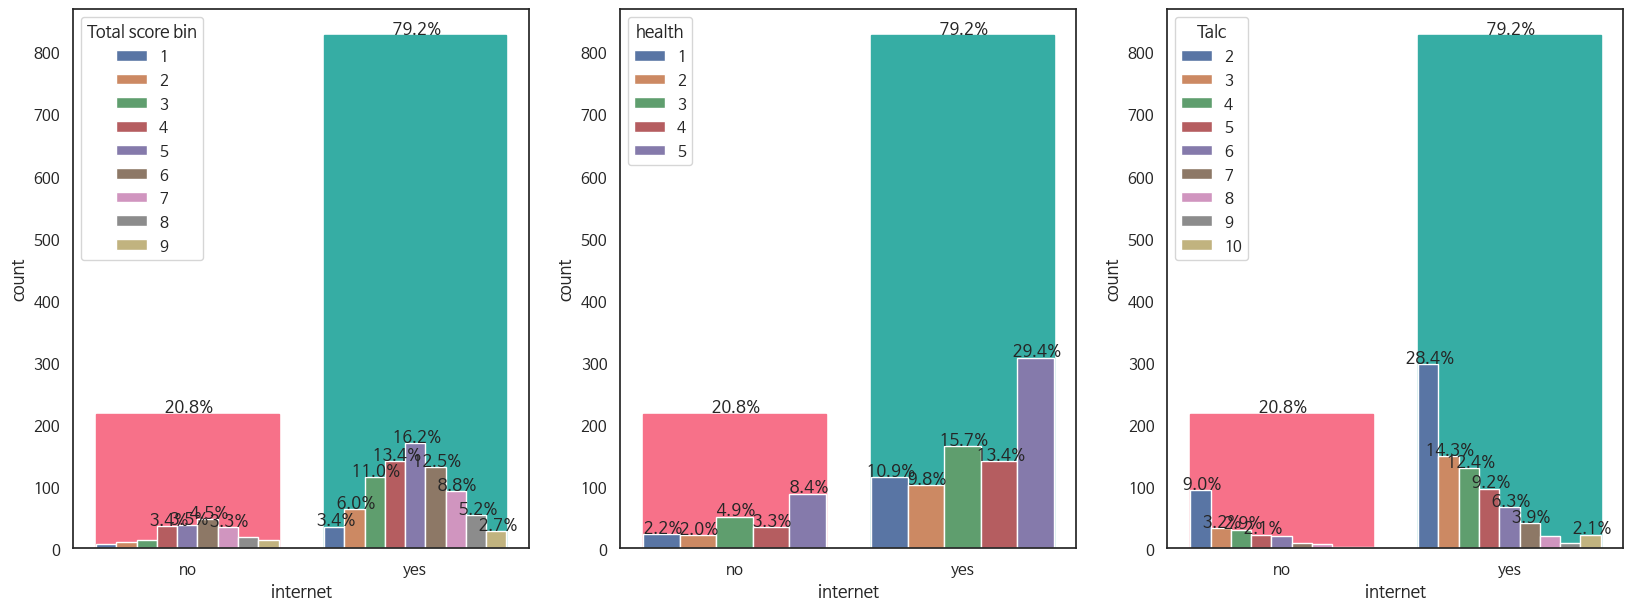

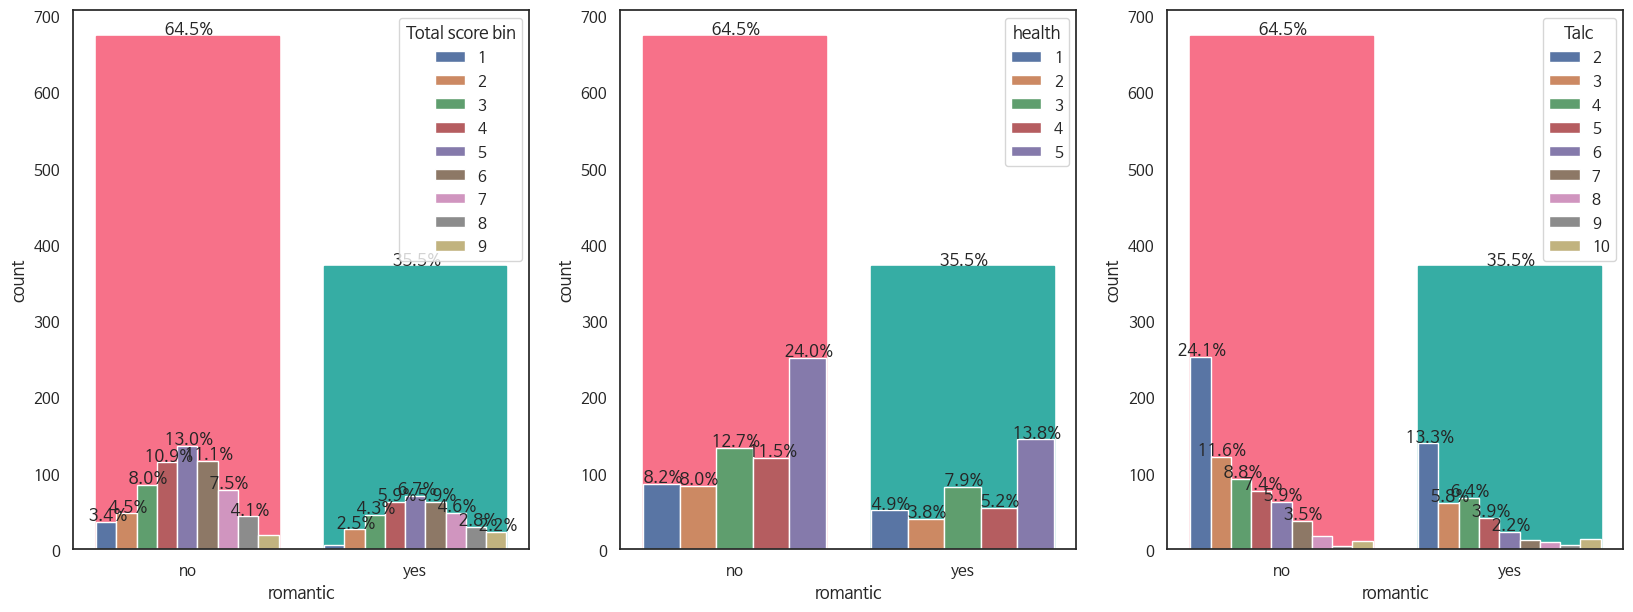

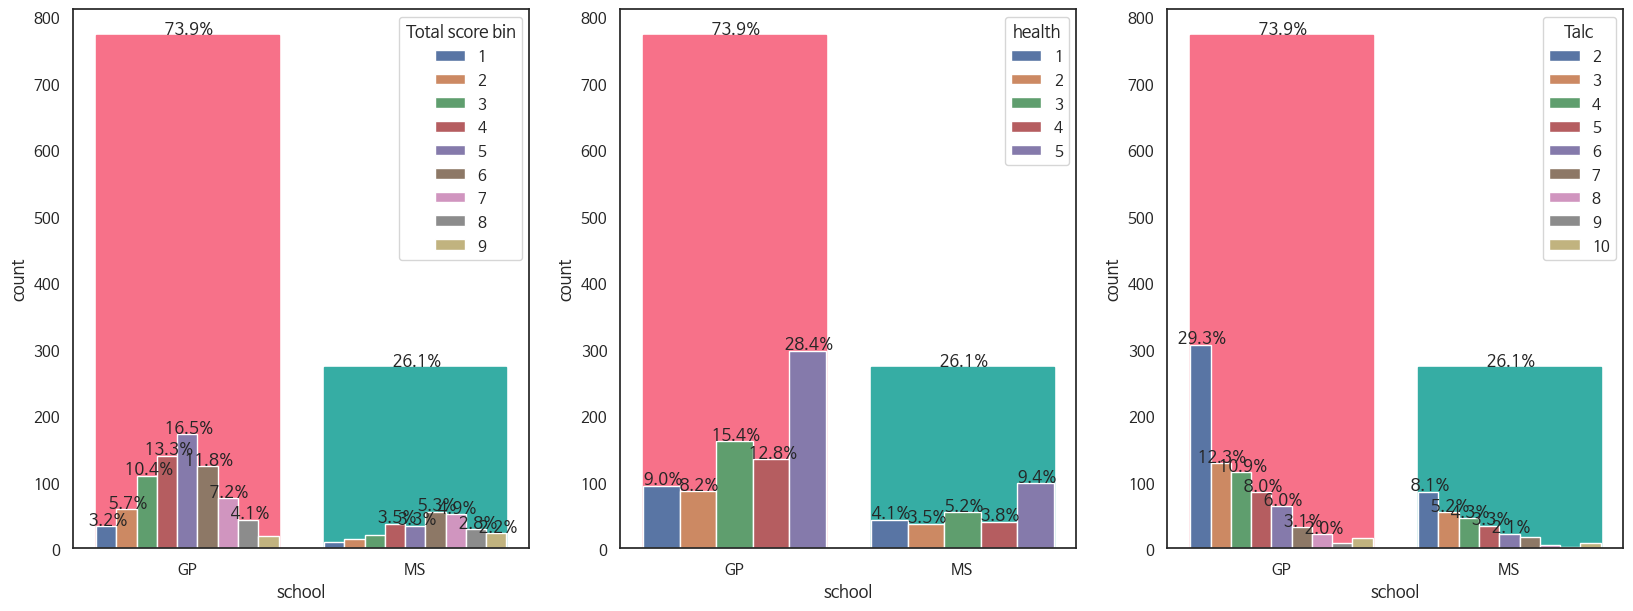

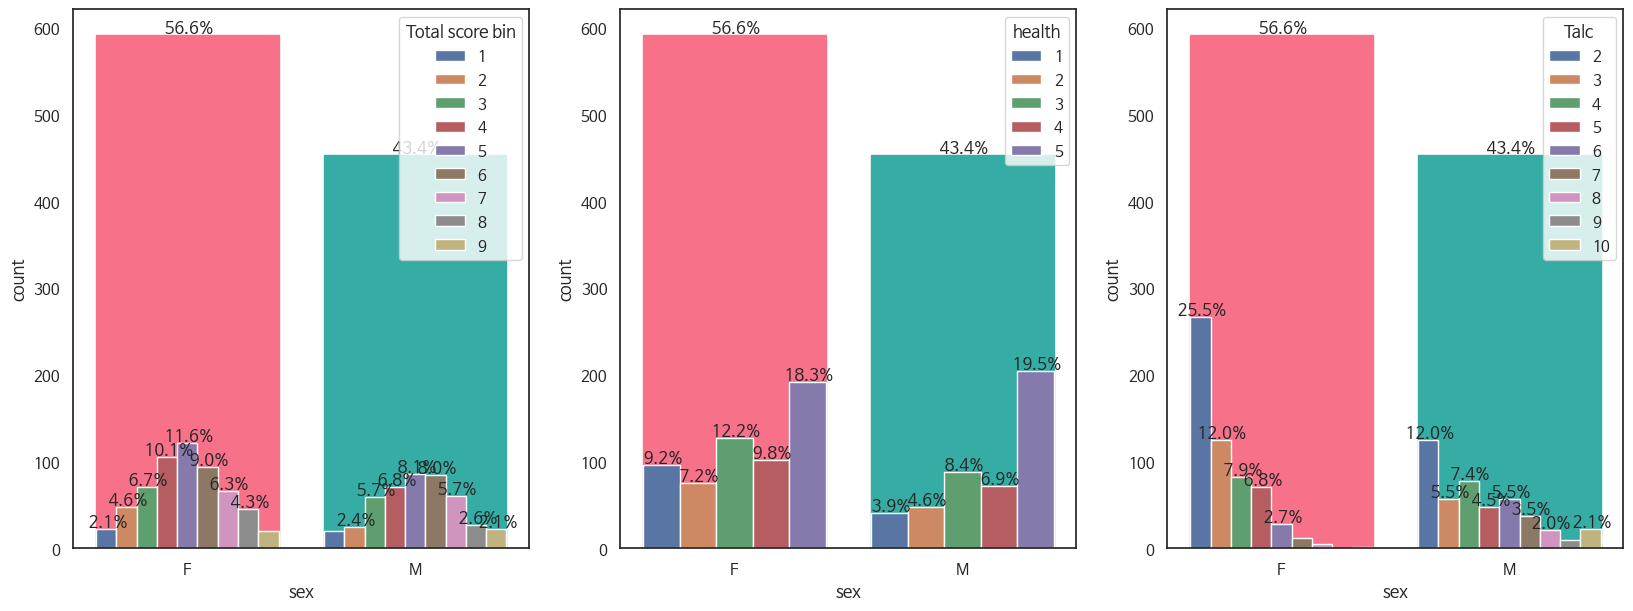

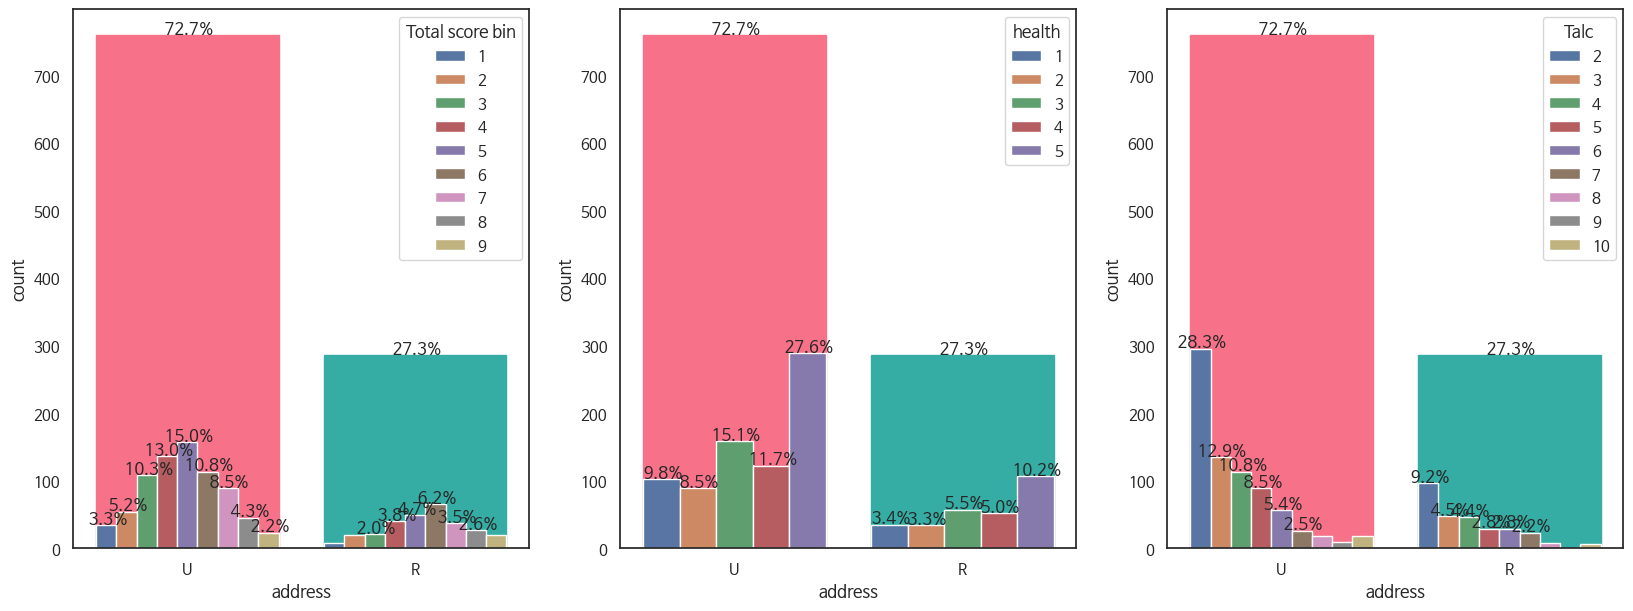

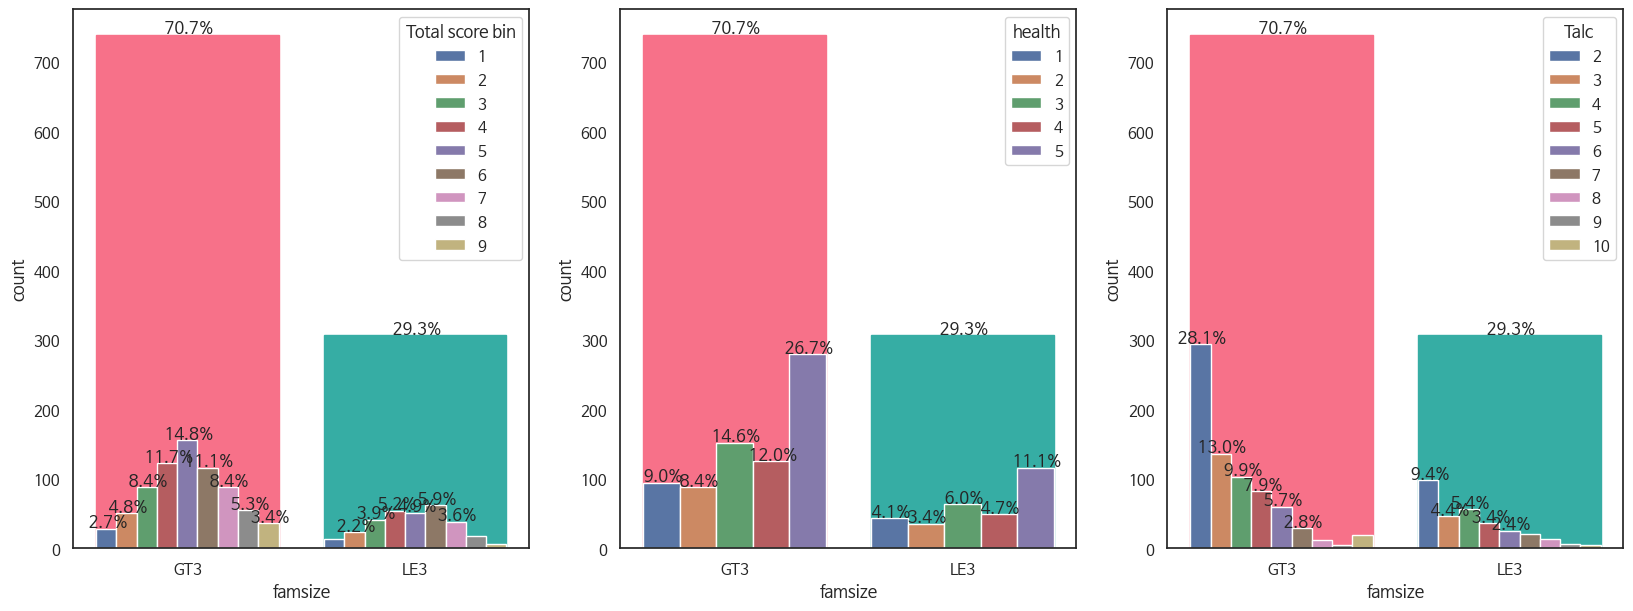

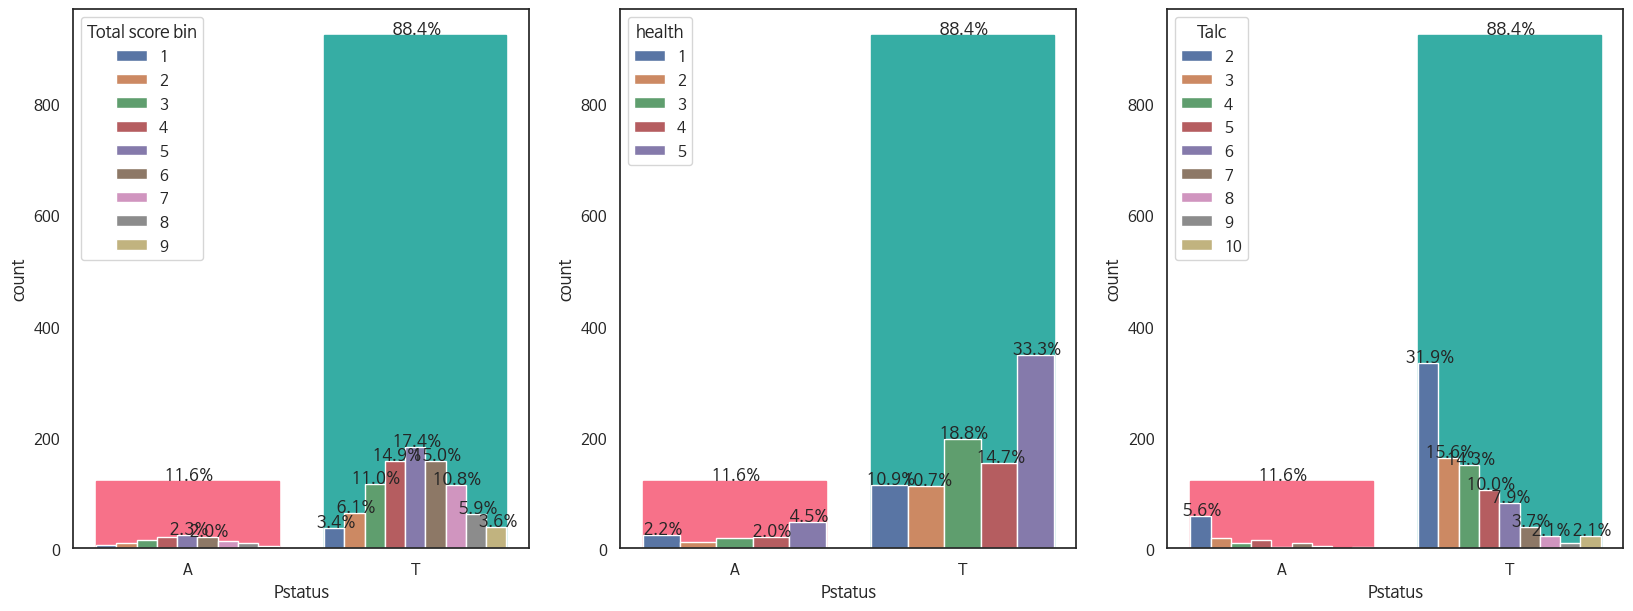

In [171]:
bin_feature = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher',  
               'internet', 'romantic', 'school', 'sex', 'address', 'famsize', 'Pstatus']


for idx, feature in enumerate(bin_feature):
    plt.figure(figsize=(20,7))
    ax = plt.subplot(1,3,1)
    sns.countplot(x=feature,
                 data=both,
                 ax=ax)
    for idx in range(len(ax.patches)):
        ax.patches[idx].set_color(sns.husl_palette(len(ax.patches))[idx])
    sns.countplot(x=feature,
                 data=both,
                  hue="GT_scale_rank_bin",
                 ax=ax)
    write_percent(ax, len(both))
    plt.legend(title="Total score bin")
    
    ax = plt.subplot(1,3,2)
    sns.countplot(x=feature,
                 data=both,
                 ax=ax)
    for idx in range(len(ax.patches)):
        ax.patches[idx].set_color(sns.husl_palette(len(ax.patches))[idx])
    sns.countplot(x=feature,
                 data=both,
                  hue="health",
                 ax=ax)
    write_percent(ax, len(both))
    
    ax = plt.subplot(1,3,3)
    sns.countplot(x=feature,
                 data=both,
                 ax=ax)
    for idx in range(len(ax.patches)):
        ax.patches[idx].set_color(sns.husl_palette(len(ax.patches))[idx])
    sns.countplot(x=feature,
                 data=both,
                  hue="Talc",
                 ax=ax)
    write_percent(ax, len(both))
    plt.show()

## Nominal feature 의 전반적인 EDA

In [338]:
def write_percent(ax, total_size):
    # total_size는 데이터의 길이 len(df) 를 사용하면 된다.
    
    # patch 그래프 막대 0~
    for idx, patch in enumerate(ax.patches):
        height = patch.get_height() # 높이(데이터 개수)
        width = patch.get_width() # 너비
        left_coord = patch.get_x() # 왼족 테두리의 x 좌표
        percent = height/total_size*100 # 타겟값 비율
        if percent >=2:
            ax.text(x=left_coord + width/2.0, # x 축 위치
                    y=height+total_size*0.003, # y 축 위치
                    s=f"{percent : 1.1f}%", # 입력될 텍스트
                    ha="center") # 가운데 정렬

def get_crosstab(df, feature, target="target"):
    # 교차분석표
    crosstab = pd.crosstab(df[feature], df[target], normalize="index")*100
    crosstab = crosstab.reset_index()
    return crosstab

def get_crosstab_mean(df, feature, target="target"):
    # 교차분석표
    crosstab = pd.crosstab(df[feature], df[target])
    crosstab["count"] = crosstab.sum(axis=1)
    for i in crosstab.columns[:-1]:
        crosstab[i] = crosstab[i]*i
    crosstab["sum"] = crosstab.sum(axis=1)
    crosstab["mean"] = crosstab["sum"] / crosstab["count"]
    crosstab = crosstab.reset_index()
    return crosstab

def plot_pointplot(ax, feature, crosstab, target):
    
    ax2= ax.twinx() # x 축은 공유하고 y 축은 공유하지 않는 새로운 축
    # #새로운 축에 plot 그리기
    ax2= sns.pointplot(x=feature,y="mean", data=crosstab,
                      order=crosstab[feature].values, # 포인트 플롯의 순서
                      color="black") # 범례표시 x
    ax2.set_ylim(crosstab["mean"].min()*0.95, crosstab["mean"].max()*1.05)
    ax2.set_ylabel(f"{target} mean")
    
def plot_cat_dist_with_true_ratio(df, features, num_rows, num_cols, target="target",size=(15,20)):

    import matplotlib.gridspec as gridspec

    plt.figure(figsize=size) # 전체 그래프의 크기
    grid = gridspec.GridSpec(num_rows, num_cols) #  서브플롯 배치
    plt.subplots_adjust(wspace=0.45, hspace=0.3) # 좌우/ 상하 여백
    
    for idx, feature in enumerate(features):
        ax = plt.subplot(grid[idx]) # x 번째 grid 그래프
        crosstab = get_crosstab(df, feature, target=target) # 교차 분석표 작성
        # ax축에 그래프 그리기
        sns.countplot(x=feature, data=df,
                     order=crosstab[feature].values,
                     ax=ax)
        for idx in range(len(ax.patches)):
            ax.patches[idx].set_color(sns.husl_palette(len(ax.patches))[idx])
        write_percent(ax, len(df)) # 비율 표시
        plot_pointplot(ax, feature, crosstab) # ax2축에 포인트 플랏그리기
        ax.set_title(f"{feature} Distribution") # 타이틀 설정

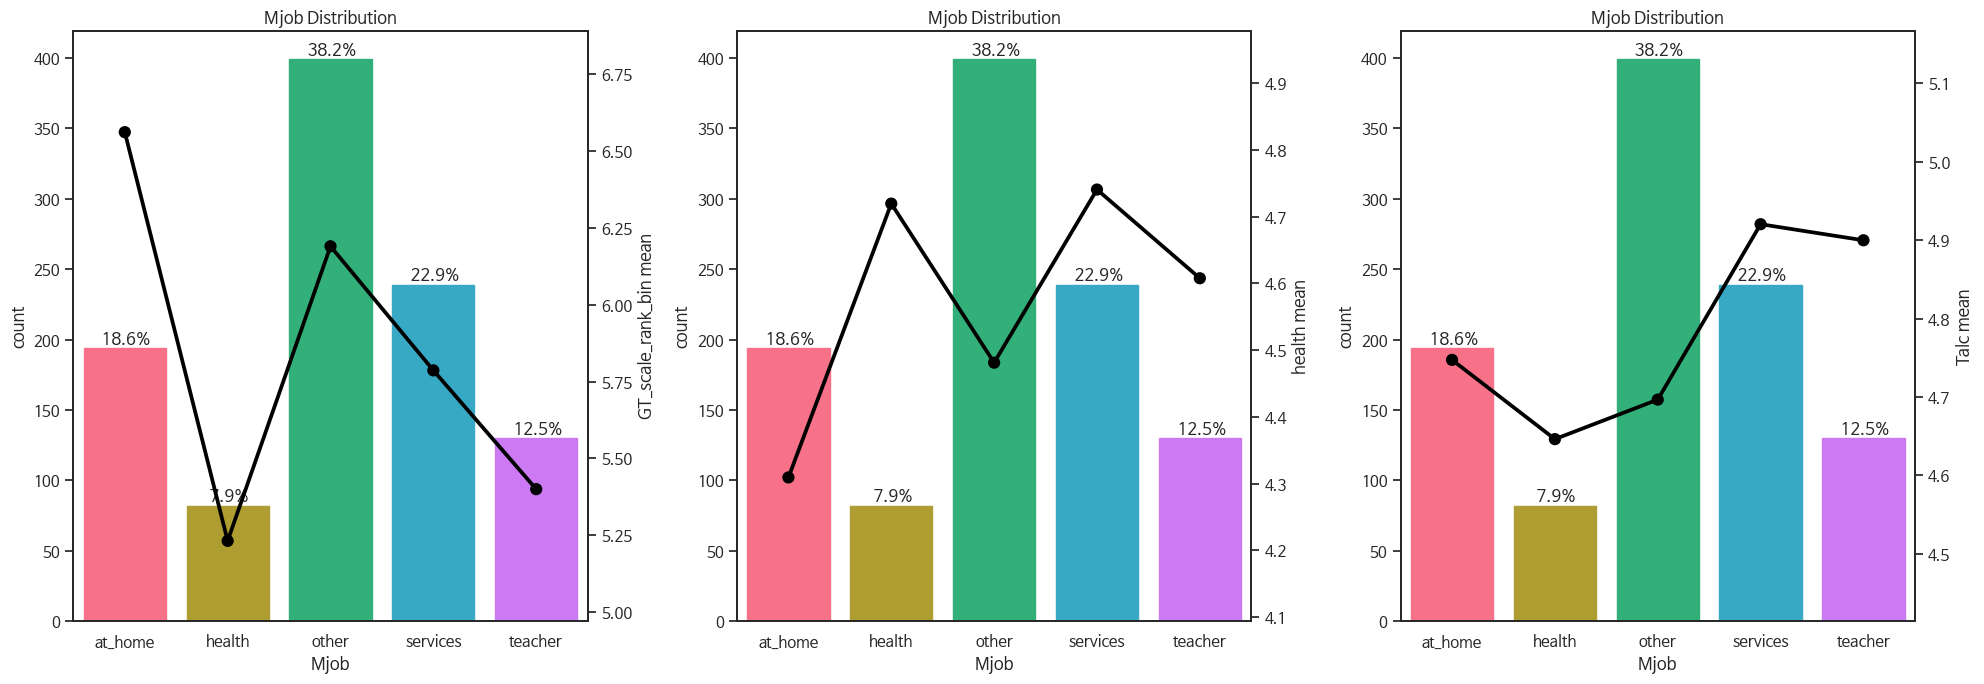

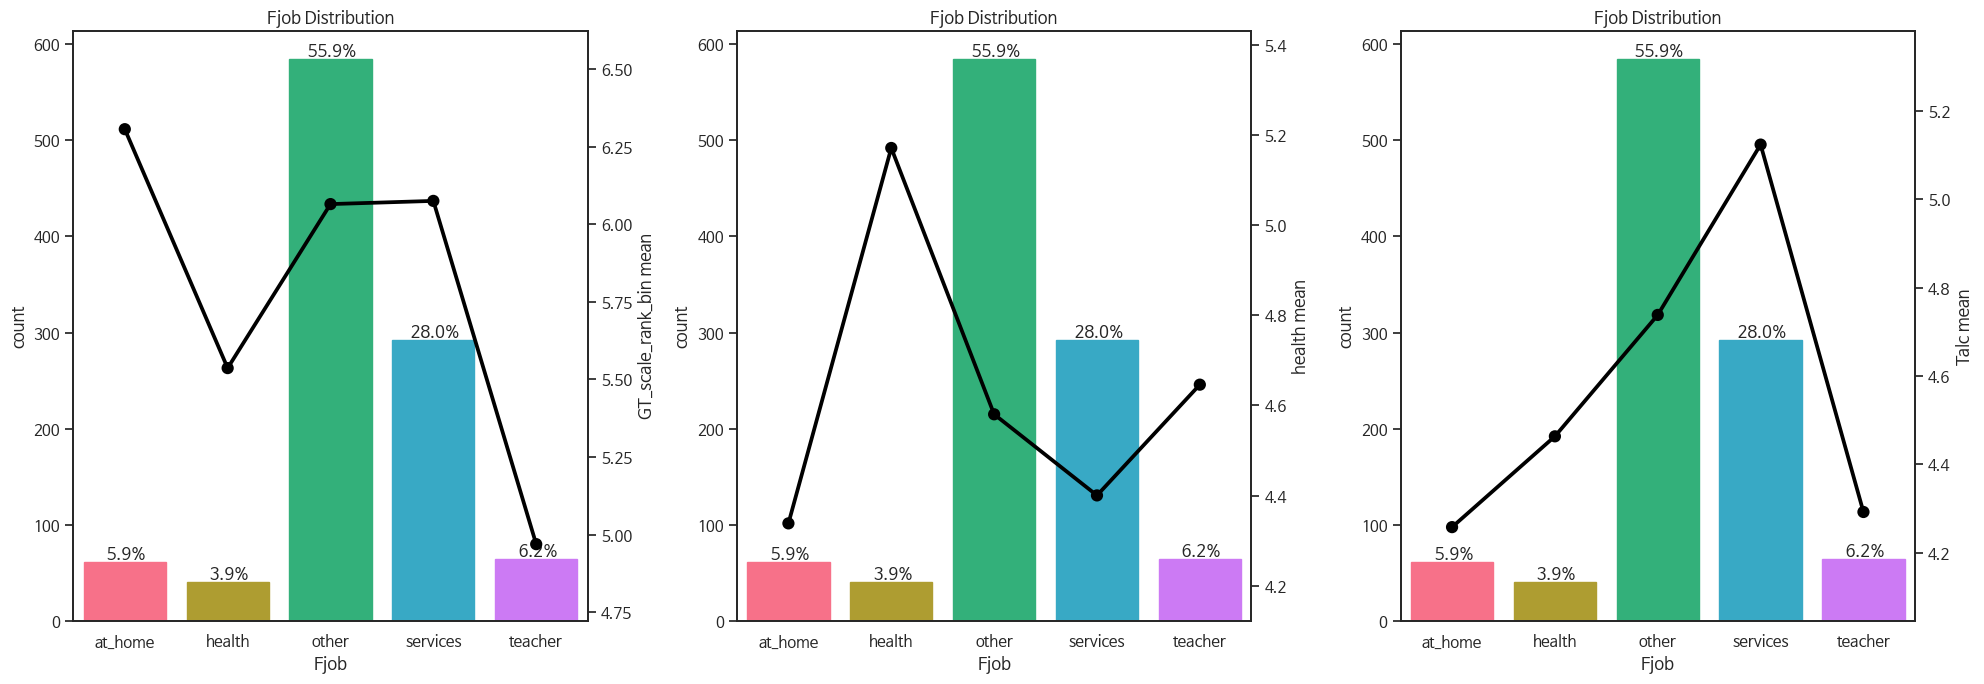

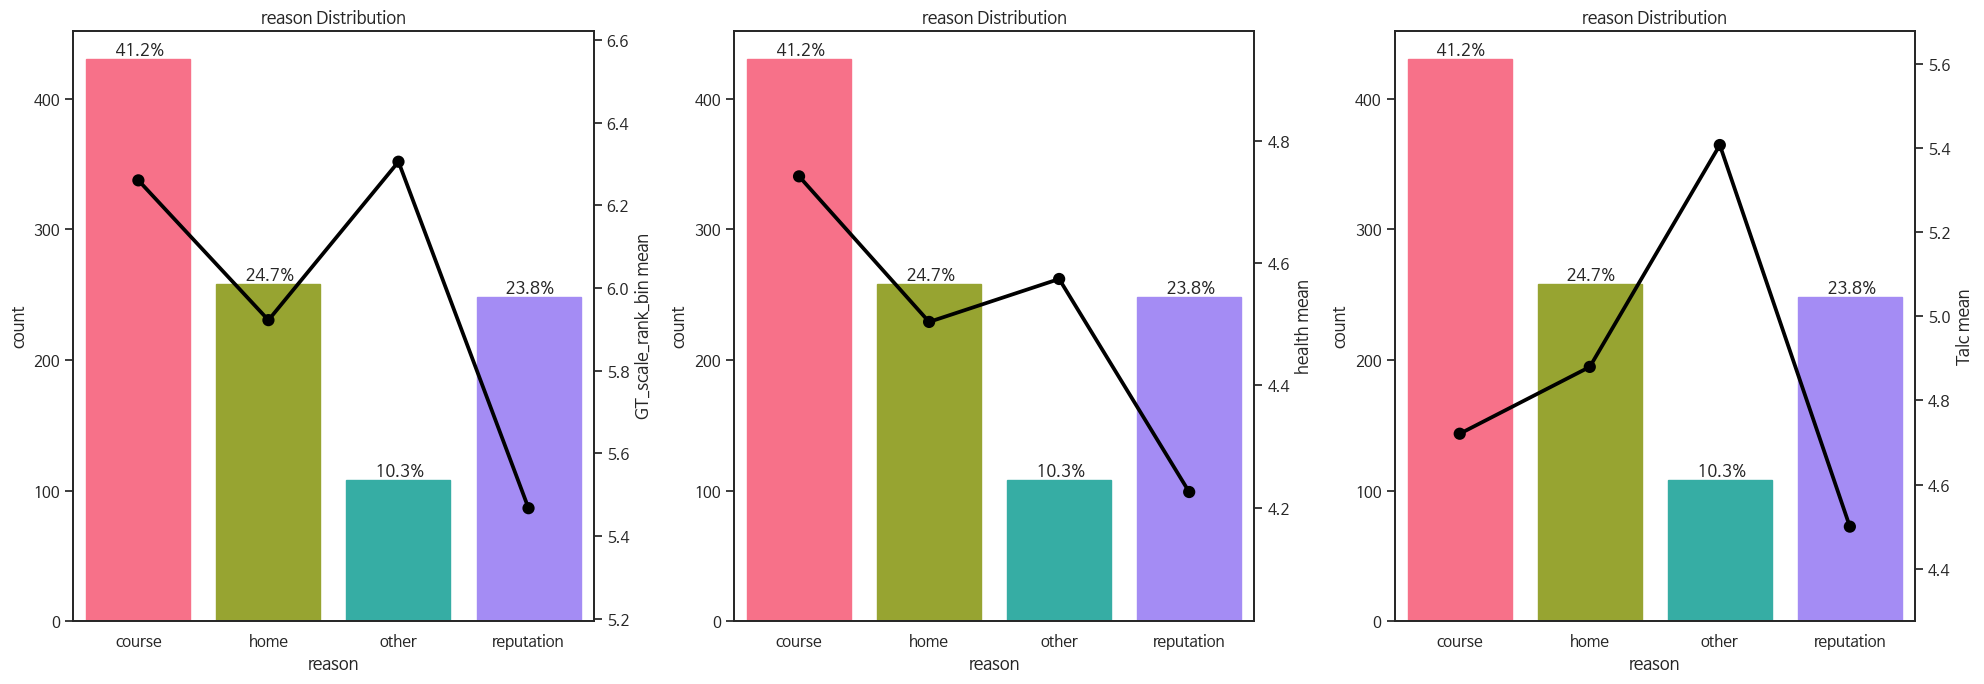

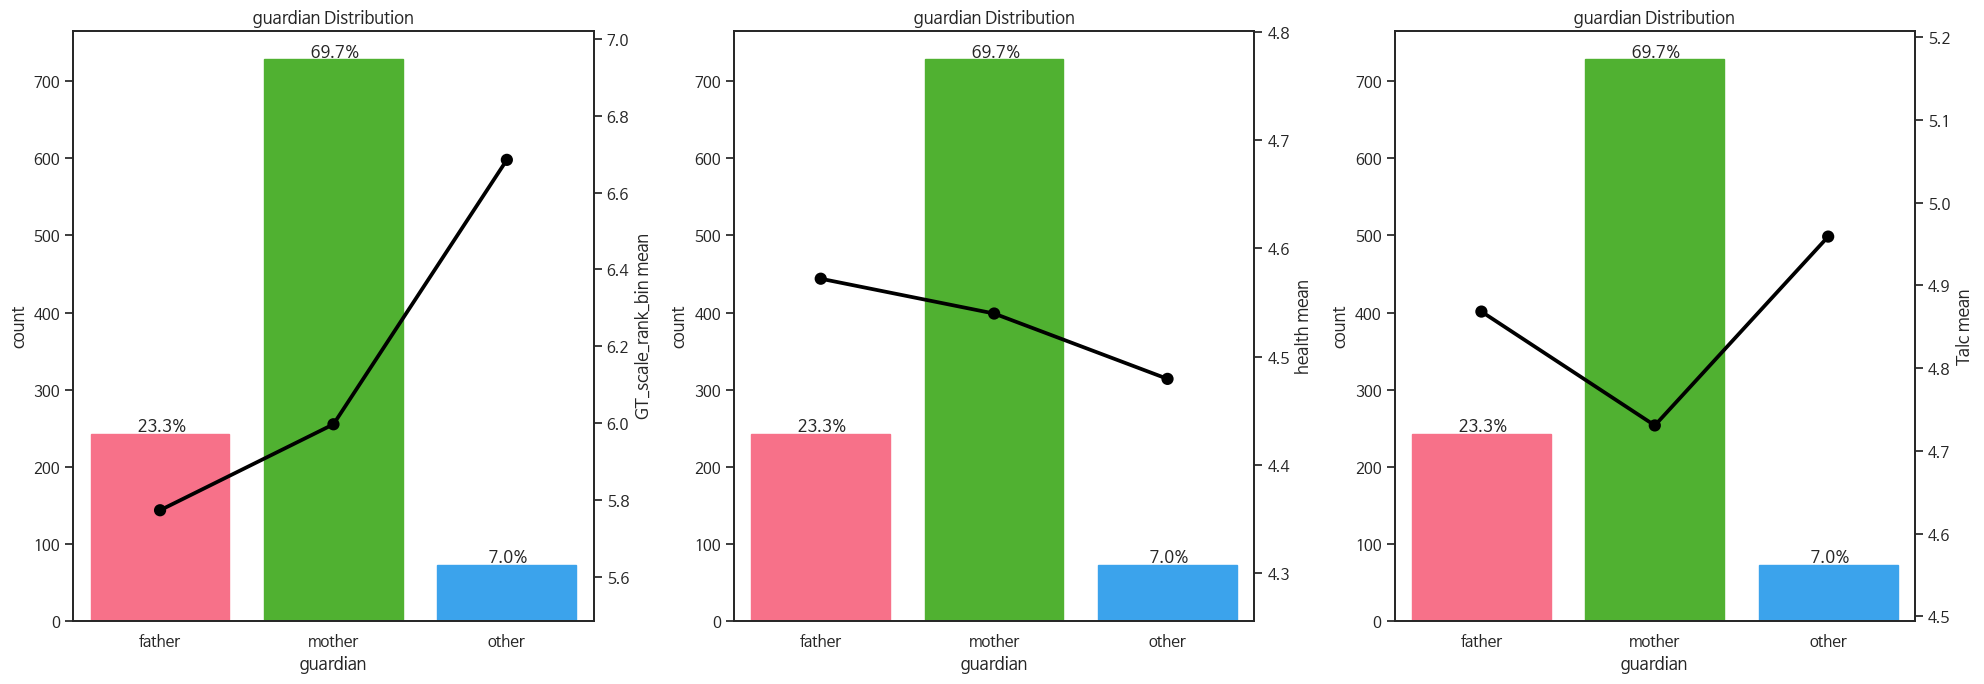

In [343]:
nom_feature = ["Mjob","Fjob","reason","guardian"]


for idx, feature in enumerate(nom_feature):
    ###
    plt.figure(figsize=(20,7))
    ax = plt.subplot(1,3,1)
    crosstab = get_crosstab_mean(both, feature, target="GT_scale_rank_bin") # 교차 분석표 작성
    # ax축에 그래프 그리기
    sns.countplot(x=feature, data=both,
                 order=crosstab[feature].values,
                 ax=ax)
    # 축에 색 넣기
    for idx in range(len(ax.patches)):
        ax.patches[idx].set_color(sns.husl_palette(len(ax.patches))[idx])
    # 비율 표시    
    write_percent(ax, len(both)) 
    # ax2축에 포인트 플랏그리기
    plot_pointplot(ax, feature, crosstab,target="GT_scale_rank_bin") 
    ax.set_title(f"{feature} Distribution") # 타이틀 설정
    
    ###
    ax = plt.subplot(1,3,2)
    crosstab = get_crosstab_mean(both, feature, target="health") # 교차 분석표 작성
    # ax축에 그래프 그리기
    sns.countplot(x=feature, data=both,
                 order=crosstab[feature].values,
                 ax=ax)
    # 축에 색 넣기
    for idx in range(len(ax.patches)):
        ax.patches[idx].set_color(sns.husl_palette(len(ax.patches))[idx])
    # 비율 표시    
    write_percent(ax, len(both)) 
    # ax2축에 포인트 플랏그리기
    plot_pointplot(ax, feature, crosstab,target="health") 
    ax.set_title(f"{feature} Distribution") # 타이틀 설정
    
    ###
    ax = plt.subplot(1,3,3)
    crosstab = get_crosstab_mean(both, feature, target="Talc") # 교차 분석표 작성
    # ax축에 그래프 그리기
    sns.countplot(x=feature, data=both,
                 order=crosstab[feature].values,
                 ax=ax)
    # 축에 색 넣기
    for idx in range(len(ax.patches)):
        ax.patches[idx].set_color(sns.husl_palette(len(ax.patches))[idx])
    # 비율 표시    
    write_percent(ax, len(both)) 
    # ax2축에 포인트 플랏그리기
    plot_pointplot(ax, feature, crosstab,target="Talc") 
    ax.set_title(f"{feature} Distribution") # 타이틀 설정
    plt.tight_layout()
    plt.show()

In [ ]:


ord_feature = ['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout']

ord_1_value = ["Novice", "Contributor", "Expert", "Master", "Grandmaster"]
ord_2_value = ["Freezing", "Cold", "Warm", "Hot", "Boiling Hot", "Lava. Hot"]

ord_1_dtype = CategoricalDtype(categories=ord_1_value, ordered=True)
ord_2_dtype = CategoricalDtype(categories=ord_2_value, ordered=True)

In [364]:
from pandas.api.types import CategoricalDtype
ord_Medu_dict = {0:"None",1:"4학년",2:"5~9학년",3:"고등학교",4:"대학이상"} 
ord_Fedu_dict = {0:"None",1:"4학년",2:"5~9학년",3:"고등학교",4:"대학이상"} 
ord_traveltime_dict = {1:"<15분",2:"15~30분",3:"30~60분",4:"60분 이상"}
ord_studytime_dict = {1:"2시간 이하",2:"2~5시간",3:"5~10시간",4:"10시간 이상"}
ord_failures_dict = {0:"없음",1:"1회", 2:"2회",3:"3회",4:"4회 이상"}
ord_famrel_dict = {1:"아주 나쁨",2:"나쁨",3:"평균",4:"좋음",5:"아주좋음"}
ord_freetime_dict = {1:"없음",2:"조금 없음",3:"평균",4:"조금 많음",5:"많음"}
ord_goout_dict = {1:"없음",2:"조금 없음",3:"평균",4:"조금 많음",5:"많음"}


both_ord = both.copy()
both_ord["Medu"] = both_ord["Medu"].apply(lambda x:ord_Medu_dict[x])
both_ord["Fedu"] = both_ord["Fedu"].apply(lambda x:ord_Fedu_dict[x])
both_ord["traveltime"] = both_ord["traveltime"].apply(lambda x:ord_traveltime_dict[x])
both_ord["studytime"] = both_ord["studytime"].apply(lambda x:ord_studytime_dict[x])
both_ord["failures"] = both_ord["failures"].apply(lambda x:ord_failures_dict[x])
both_ord["famrel"] = both_ord["famrel"].apply(lambda x:ord_famrel_dict[x])
both_ord["freetime"] = both_ord["freetime"].apply(lambda x:ord_freetime_dict[x])
both_ord["goout"] = both_ord["goout"].apply(lambda x:ord_goout_dict[x])

ord_Medu = CategoricalDtype(categories=list(ord_Medu_dict.values()), ordered=True)
ord_Fedu = CategoricalDtype(categories=list(ord_Fedu_dict.values()), ordered=True)
ord_traveltime = CategoricalDtype(categories=list(ord_traveltime_dict.values()), ordered=True)
ord_studytime = CategoricalDtype(categories=list(ord_studytime_dict.values()), ordered=True)
ord_failures = CategoricalDtype(categories=list(ord_failures_dict.values()), ordered=True)
ord_famrel = CategoricalDtype(categories=list(ord_famrel_dict.values()), ordered=True)
ord_freetime = CategoricalDtype(categories=list(ord_freetime_dict.values()), ordered=True)
ord_goout = CategoricalDtype(categories=list(ord_goout_dict.values()), ordered=True)

both_ord["Medu"] =both_ord["Medu"].astype(ord_Medu)
both_ord["Fedu"] =both_ord["Fedu"].astype(ord_Fedu)
both_ord["traveltime"] =both_ord["traveltime"].astype(ord_traveltime)
both_ord["studytime"] =both_ord["studytime"].astype(ord_studytime)
both_ord["failures"] =both_ord["failures"].astype(ord_failures)
both_ord["famrel"] =both_ord["famrel"].astype(ord_famrel)
both_ord["freetime"] =both_ord["freetime"].astype(ord_freetime)
both_ord["goout"] =both_ord["goout"].astype(ord_goout)

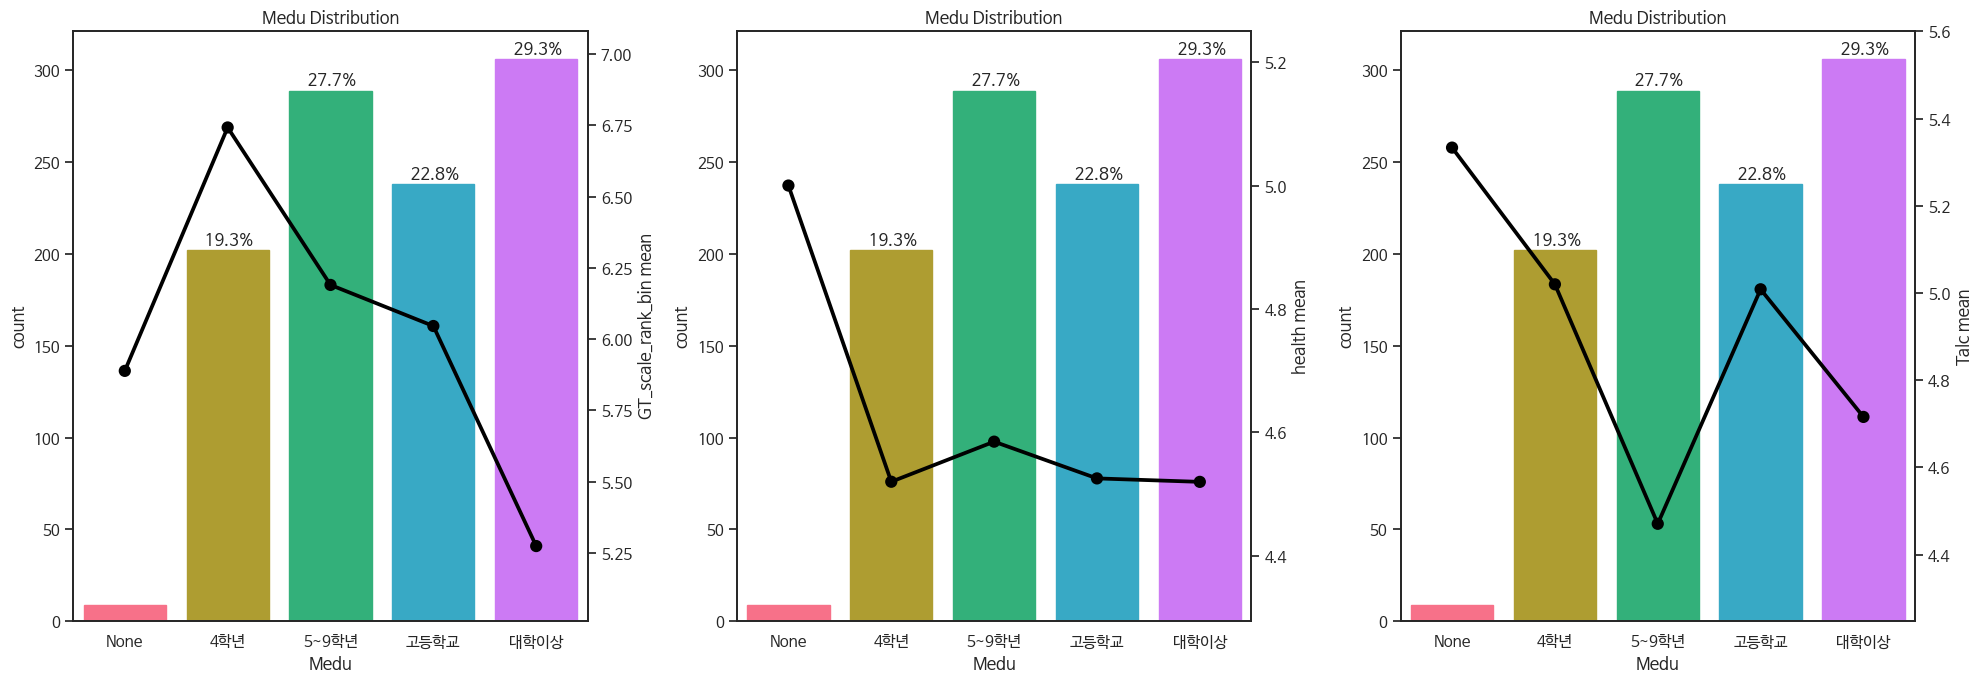

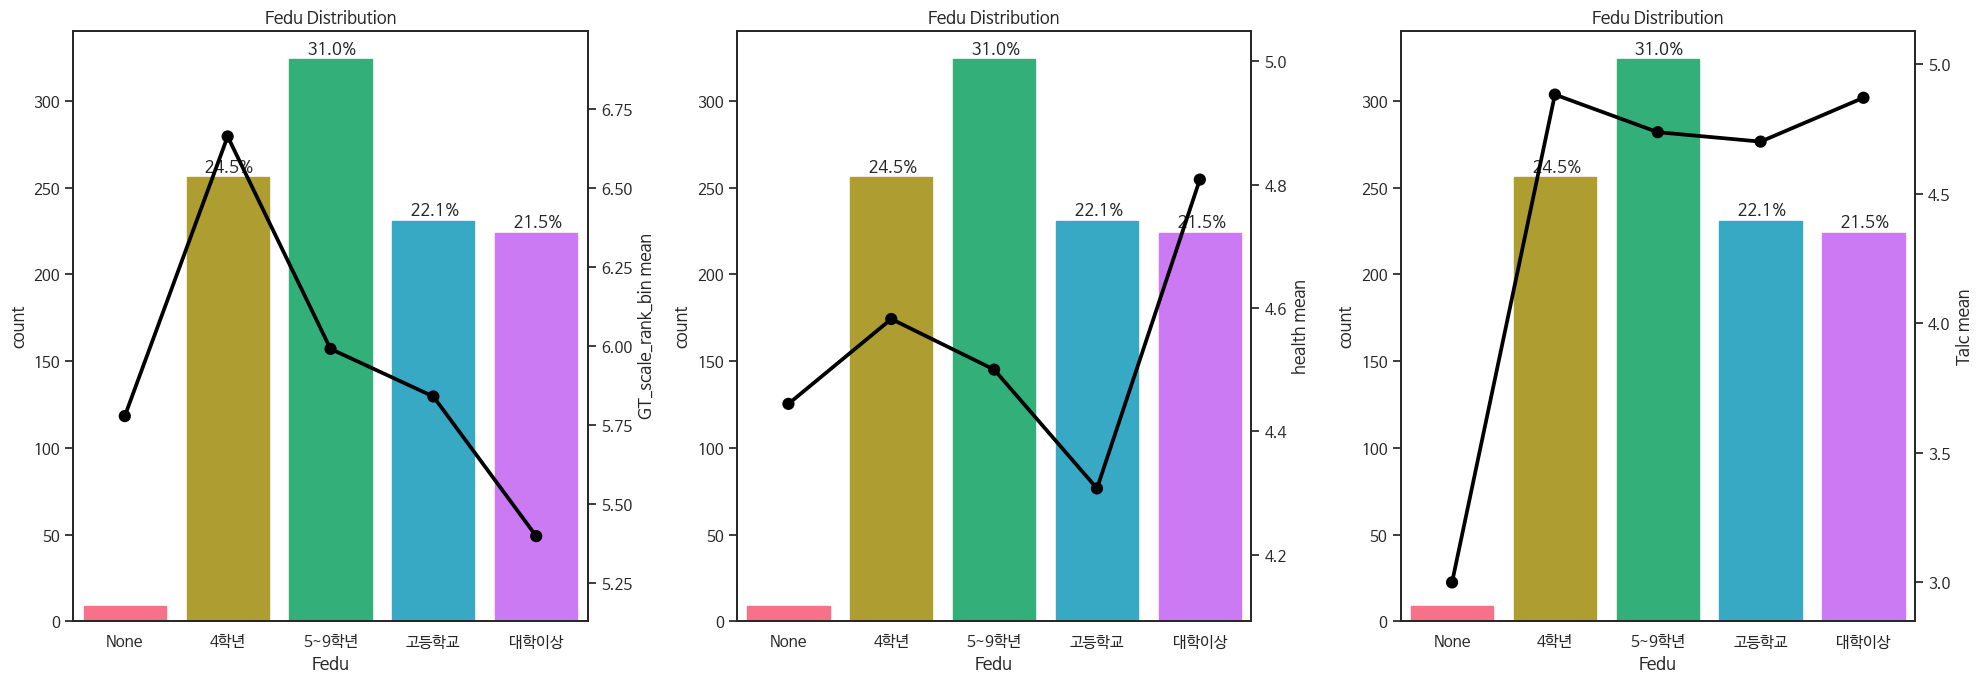

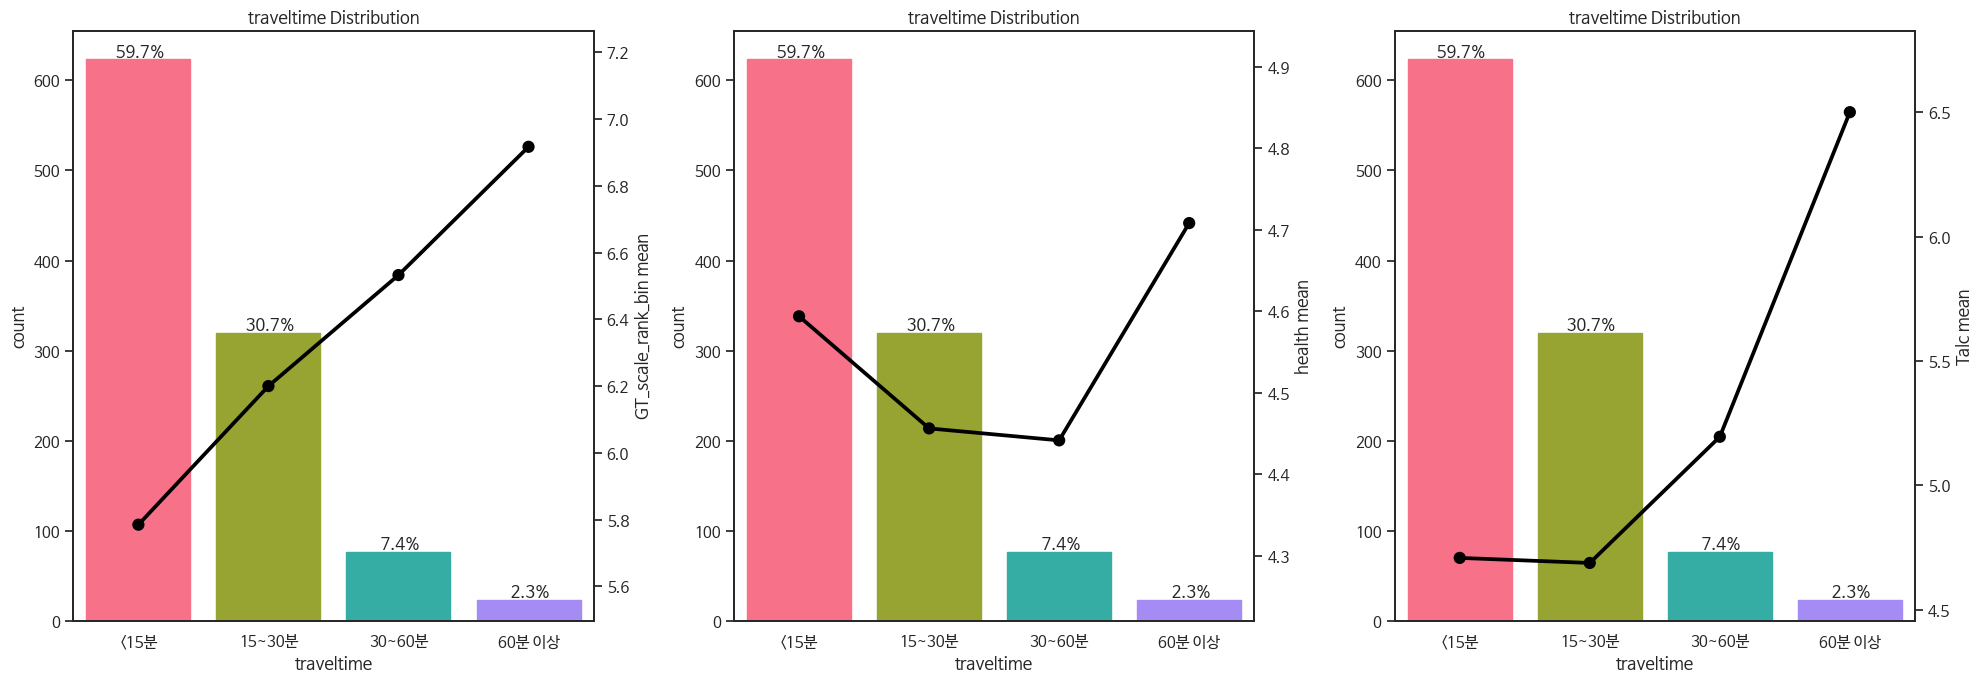

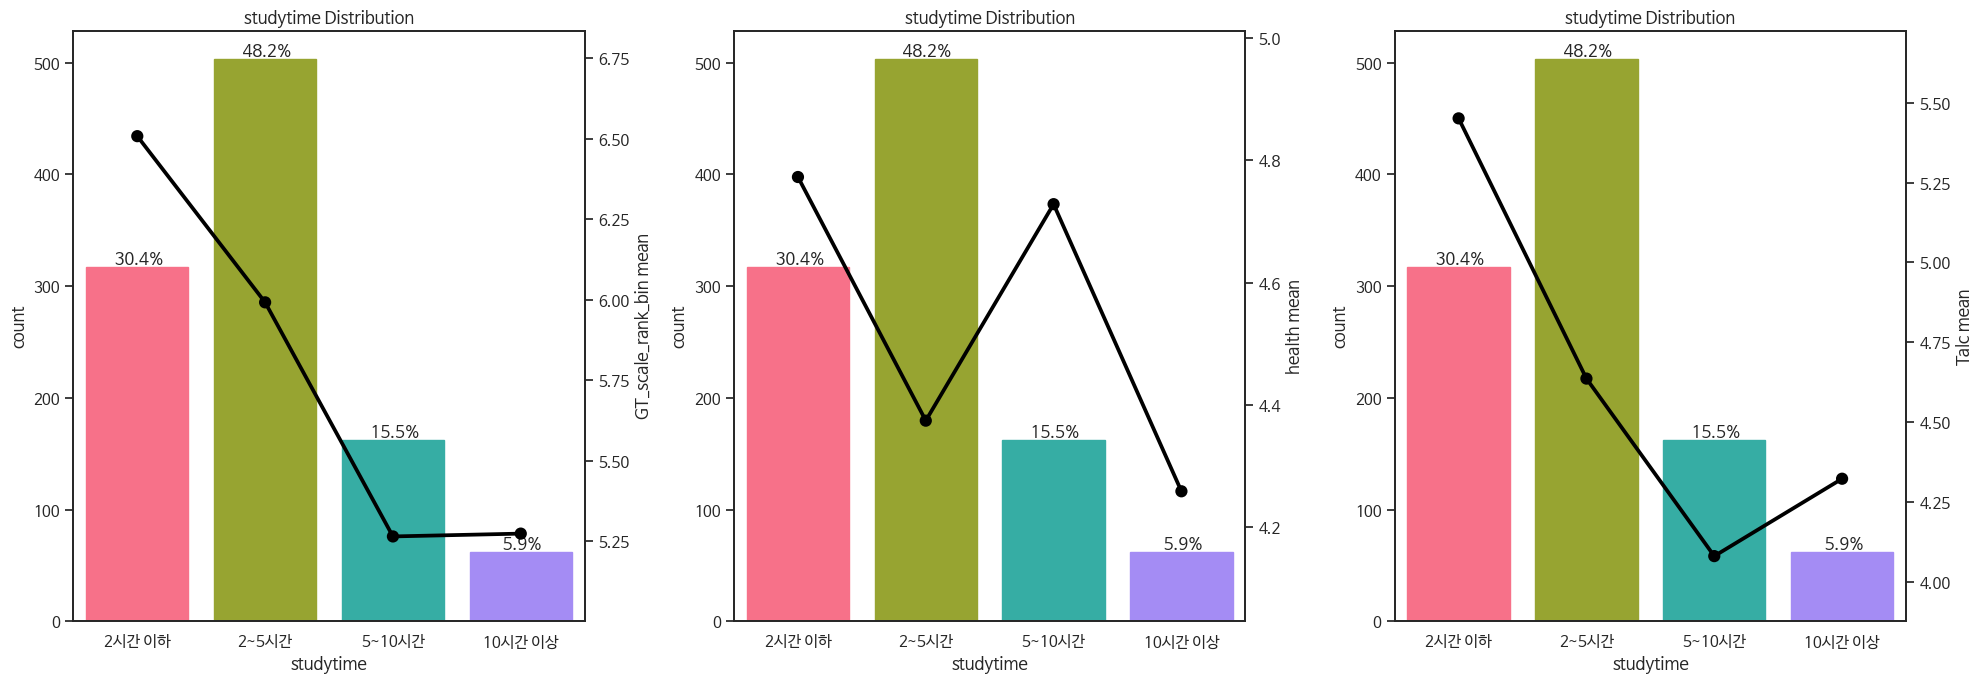

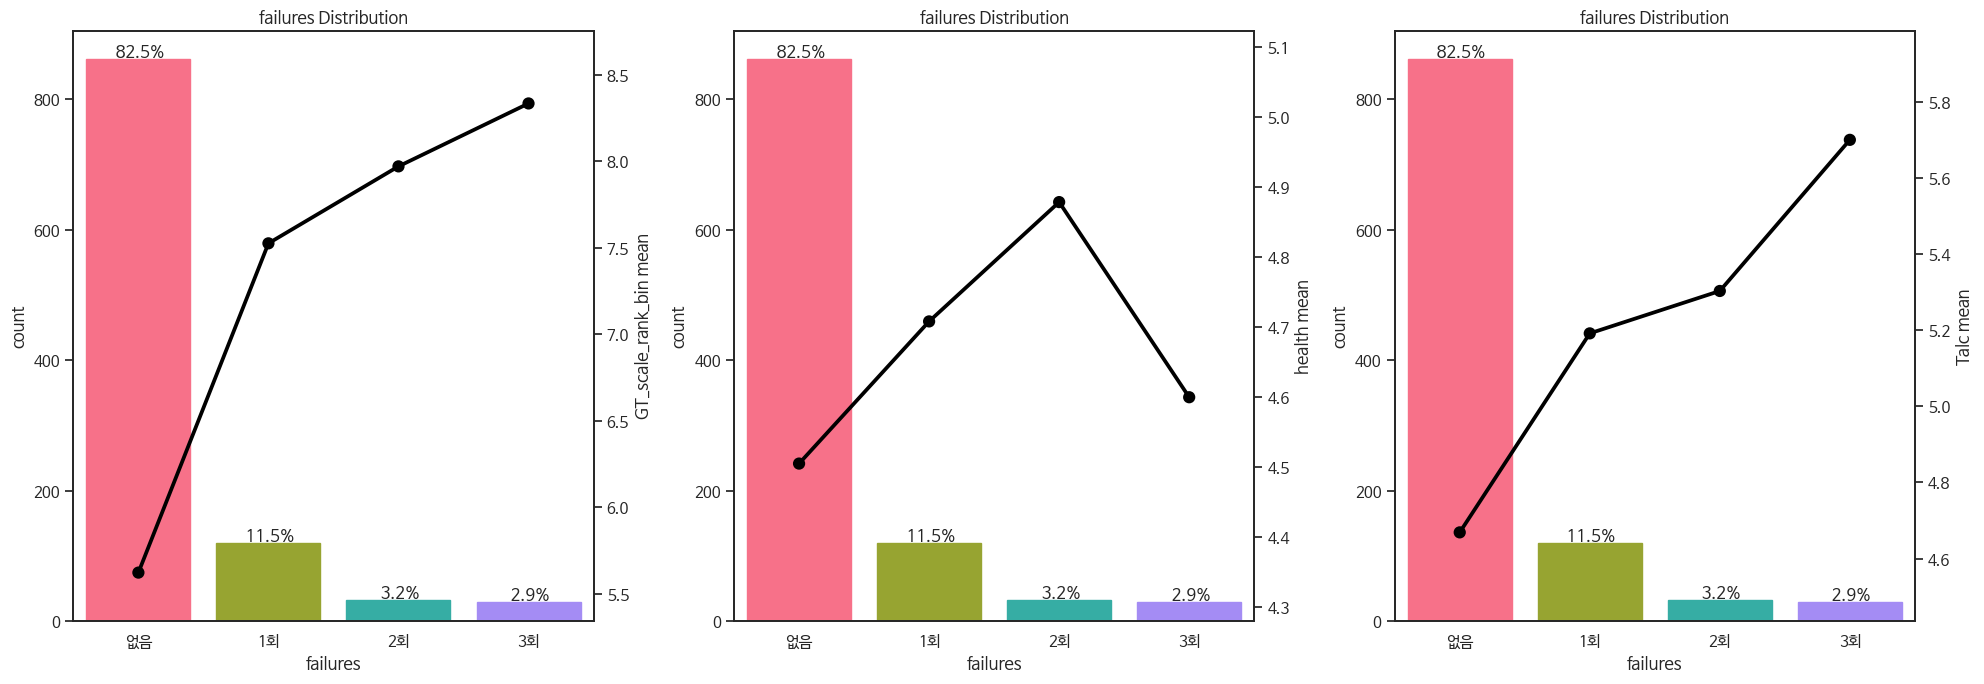

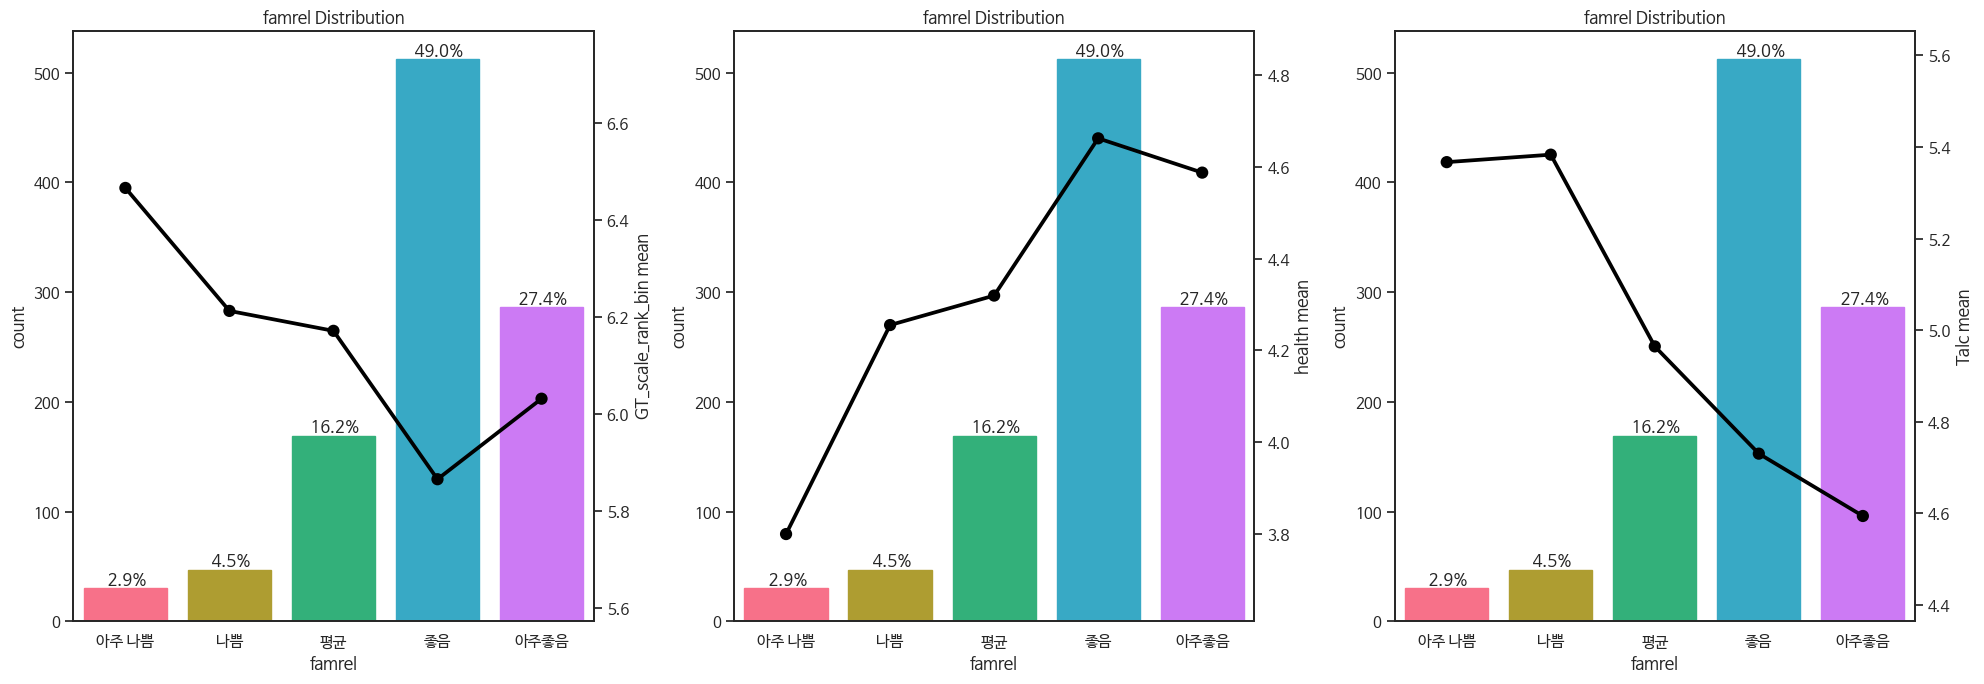

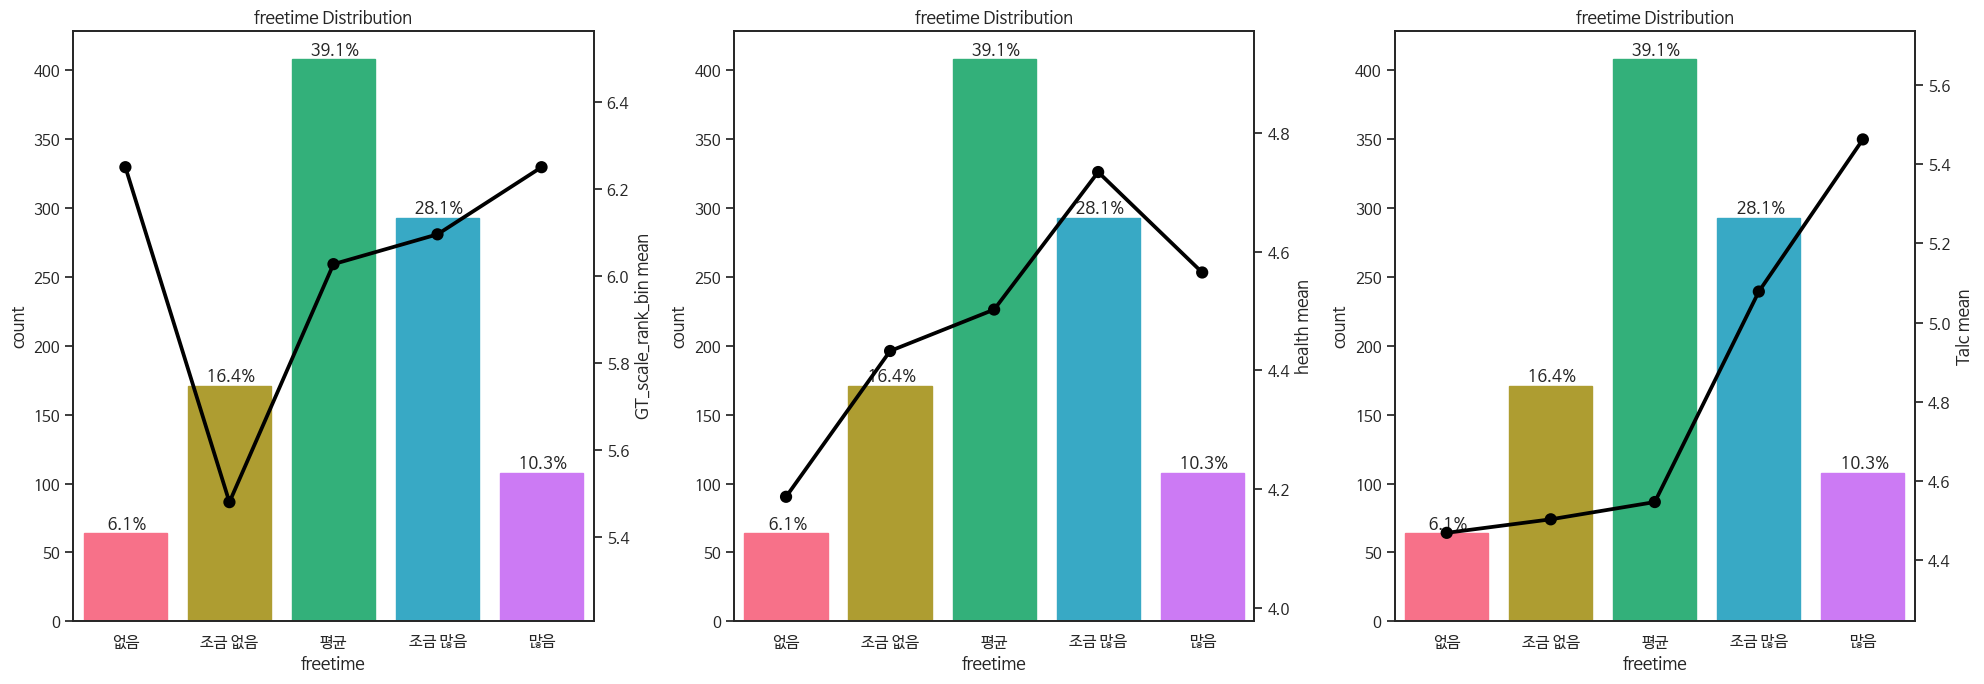

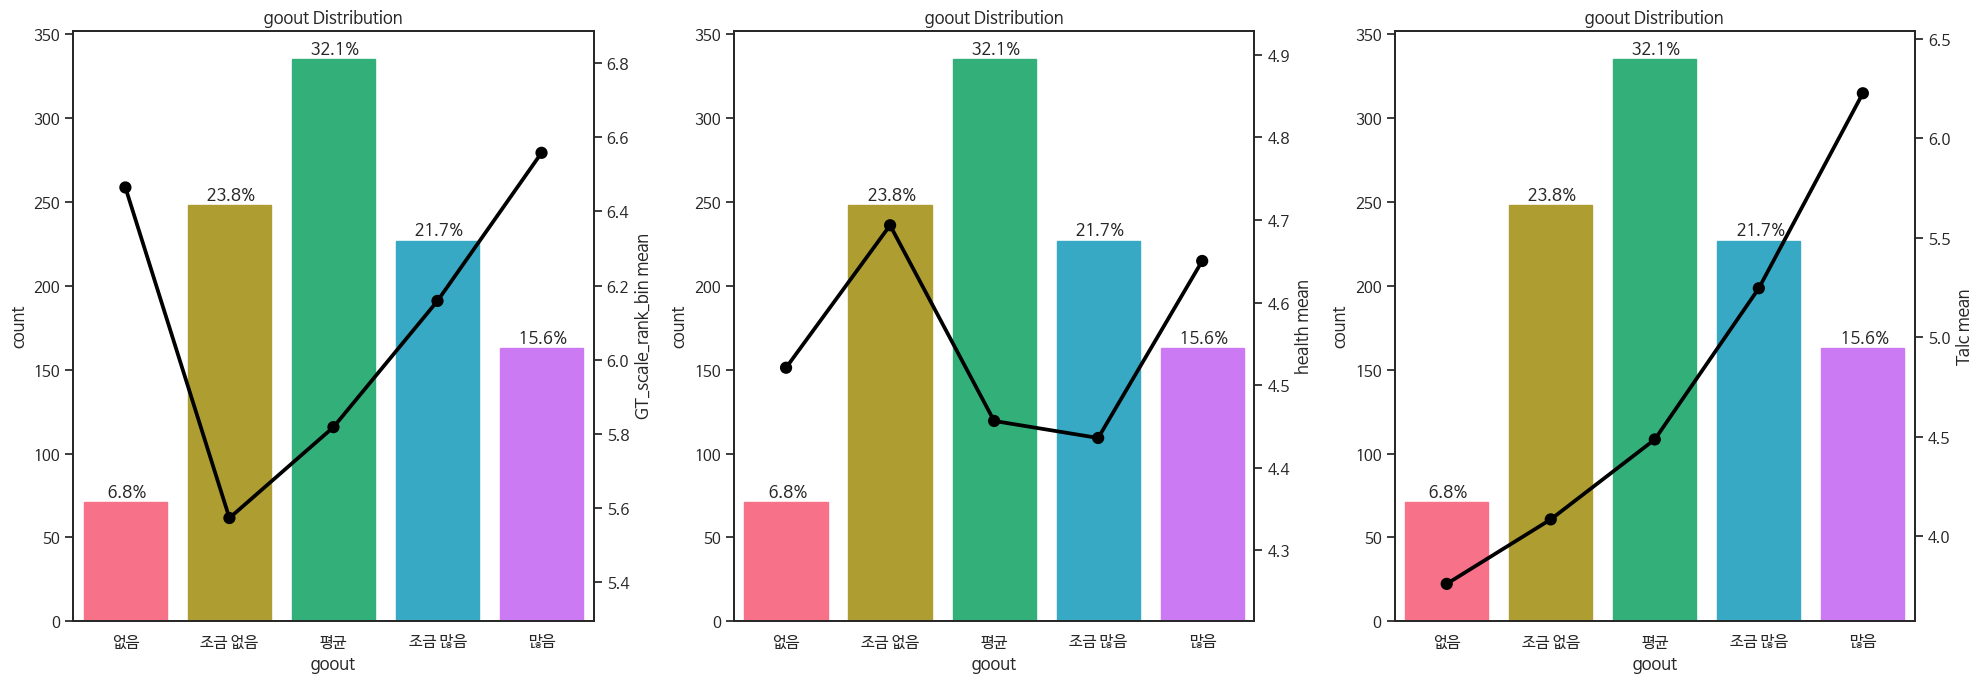

In [366]:
ord_feature = ['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout']

for idx, feature in enumerate(ord_feature):
    ###
    plt.figure(figsize=(20,7))
    ax = plt.subplot(1,3,1)
    crosstab = get_crosstab_mean(both_ord, feature, target="GT_scale_rank_bin") # 교차 분석표 작성
    # ax축에 그래프 그리기
    sns.countplot(x=feature, data=both_ord,
                 order=crosstab[feature].values,
                 ax=ax)
    # 축에 색 넣기
    for idx in range(len(ax.patches)):
        ax.patches[idx].set_color(sns.husl_palette(len(ax.patches))[idx])
    # 비율 표시    
    write_percent(ax, len(both_ord)) 
    # ax2축에 포인트 플랏그리기
    plot_pointplot(ax, feature, crosstab,target="GT_scale_rank_bin") 
    ax.set_title(f"{feature} Distribution") # 타이틀 설정
    
    ###
    ax = plt.subplot(1,3,2)
    crosstab = get_crosstab_mean(both_ord, feature, target="health") # 교차 분석표 작성
    # ax축에 그래프 그리기
    sns.countplot(x=feature, data=both_ord,
                 order=crosstab[feature].values,
                 ax=ax)
    # 축에 색 넣기
    for idx in range(len(ax.patches)):
        ax.patches[idx].set_color(sns.husl_palette(len(ax.patches))[idx])
    # 비율 표시    
    write_percent(ax, len(both_ord)) 
    # ax2축에 포인트 플랏그리기
    plot_pointplot(ax, feature, crosstab,target="health") 
    ax.set_title(f"{feature} Distribution") # 타이틀 설정
    
    ###
    ax = plt.subplot(1,3,3)
    crosstab = get_crosstab_mean(both_ord, feature, target="Talc") # 교차 분석표 작성
    # ax축에 그래프 그리기
    sns.countplot(x=feature, data=both_ord,
                 order=crosstab[feature].values,
                 ax=ax)
    # 축에 색 넣기
    for idx in range(len(ax.patches)):
        ax.patches[idx].set_color(sns.husl_palette(len(ax.patches))[idx])
    # 비율 표시    
    write_percent(ax, len(both_ord)) 
    # ax2축에 포인트 플랏그리기
    plot_pointplot(ax, feature, crosstab,target="Talc") 
    ax.set_title(f"{feature} Distribution") # 타이틀 설정
    plt.tight_layout()
    plt.show()

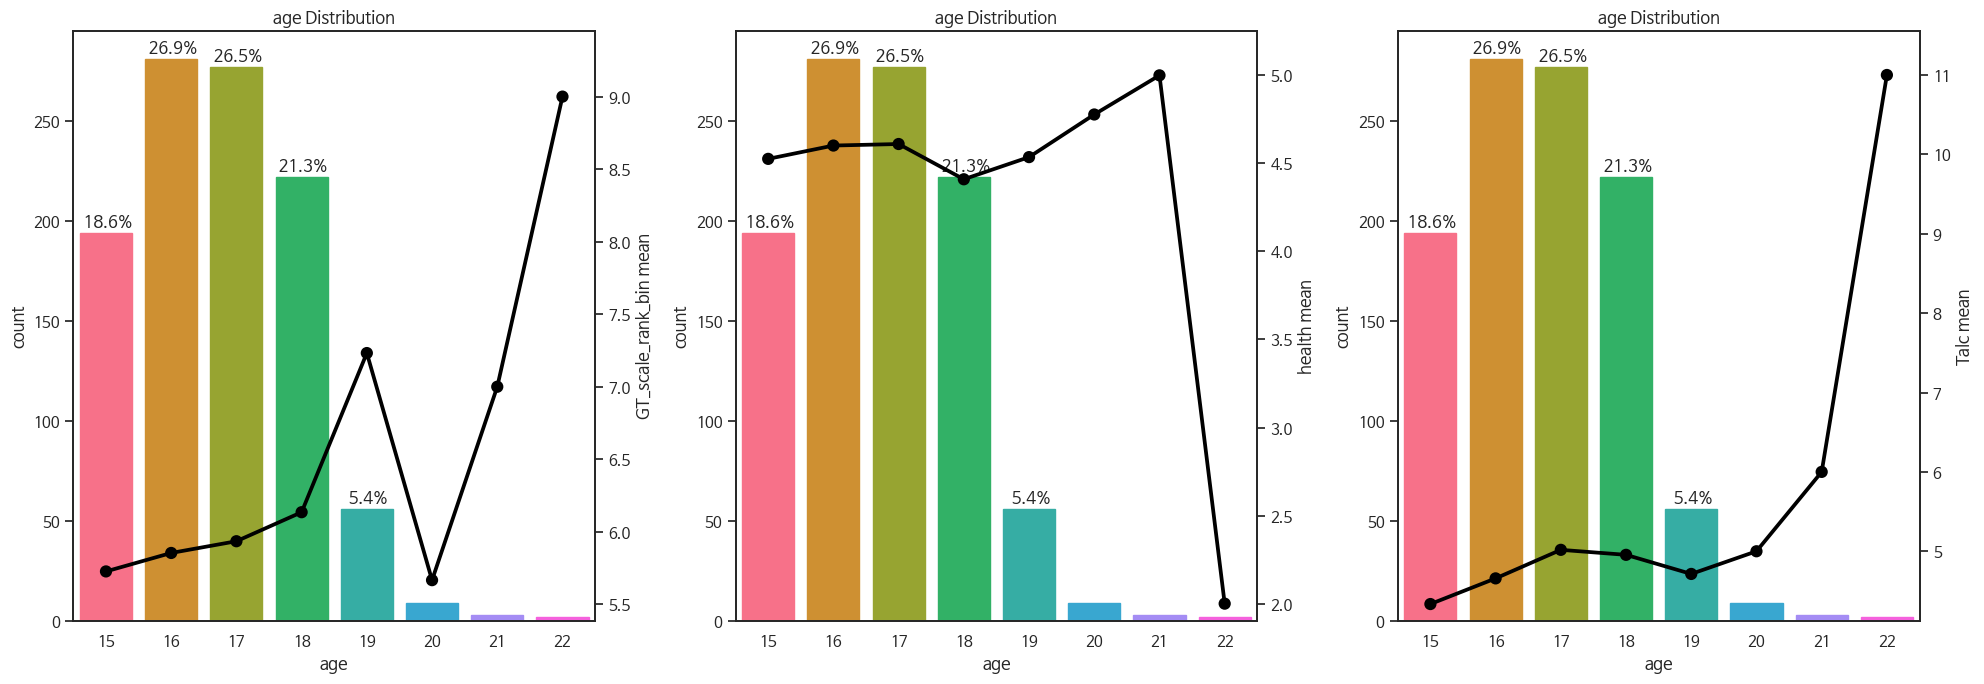

In [372]:
num_feature = ['age']

for idx, feature in enumerate(num_feature):
    ###
    plt.figure(figsize=(20,7))
    ax = plt.subplot(1,3,1)
    crosstab = get_crosstab_mean(both, feature, target="GT_scale_rank_bin") # 교차 분석표 작성
    # ax축에 그래프 그리기
    sns.countplot(x=feature, data=both,
                 order=crosstab[feature].values,
                 ax=ax)
    # 축에 색 넣기
    for idx in range(len(ax.patches)):
        ax.patches[idx].set_color(sns.husl_palette(len(ax.patches))[idx])
    # 비율 표시    
    write_percent(ax, len(both)) 
    # ax2축에 포인트 플랏그리기
    plot_pointplot(ax, feature, crosstab,target="GT_scale_rank_bin") 
    ax.set_title(f"{feature} Distribution") # 타이틀 설정
    
    ###
    ax = plt.subplot(1,3,2)
    crosstab = get_crosstab_mean(both, feature, target="health") # 교차 분석표 작성
    # ax축에 그래프 그리기
    sns.countplot(x=feature, data=both,
                 order=crosstab[feature].values,
                 ax=ax)
    # 축에 색 넣기
    for idx in range(len(ax.patches)):
        ax.patches[idx].set_color(sns.husl_palette(len(ax.patches))[idx])
    # 비율 표시    
    write_percent(ax, len(both)) 
    # ax2축에 포인트 플랏그리기
    plot_pointplot(ax, feature, crosstab,target="health") 
    ax.set_title(f"{feature} Distribution") # 타이틀 설정
    
    ###
    ax = plt.subplot(1,3,3)
    crosstab = get_crosstab_mean(both, feature, target="Talc") # 교차 분석표 작성
    # ax축에 그래프 그리기
    sns.countplot(x=feature, data=both,
                 order=crosstab[feature].values,
                 ax=ax)
    # 축에 색 넣기
    for idx in range(len(ax.patches)):
        ax.patches[idx].set_color(sns.husl_palette(len(ax.patches))[idx])
    # 비율 표시    
    write_percent(ax, len(both)) 
    # ax2축에 포인트 플랏그리기
    plot_pointplot(ax, feature, crosstab,target="Talc") 
    ax.set_title(f"{feature} Distribution") # 타이틀 설정
    plt.tight_layout()
    plt.show()

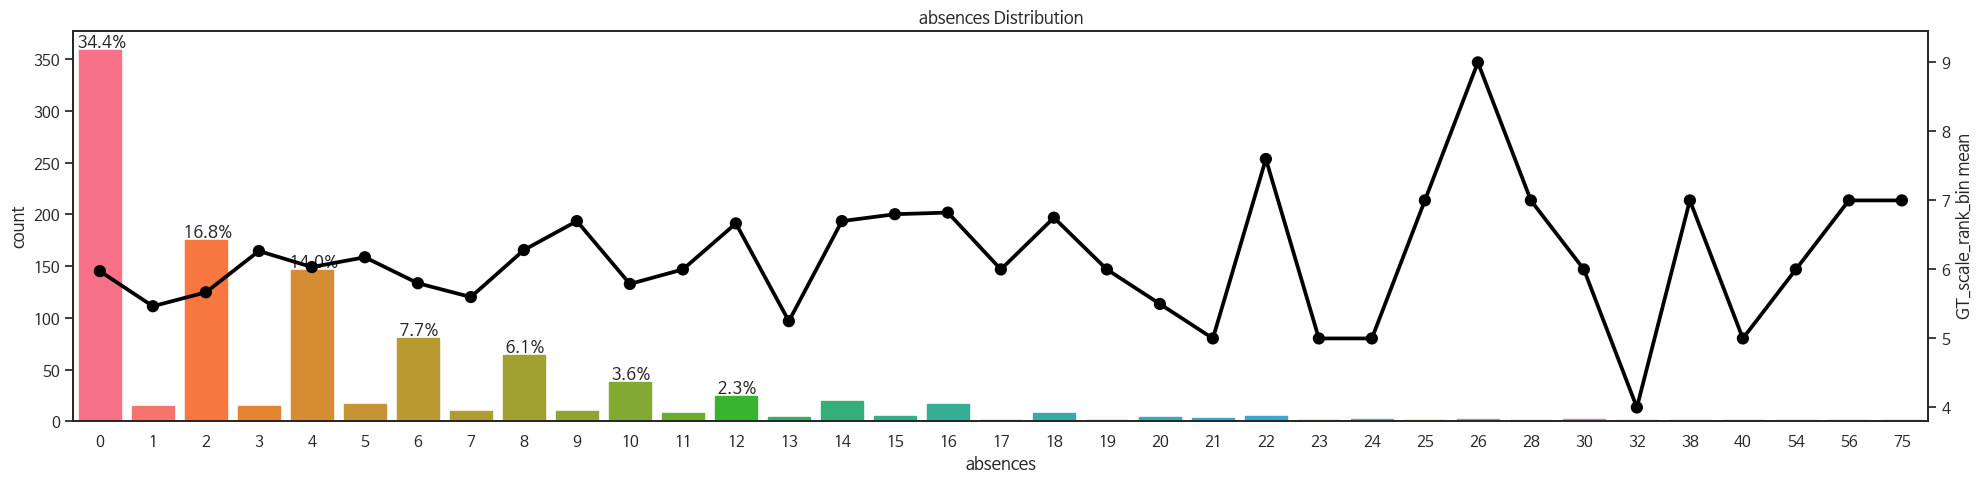

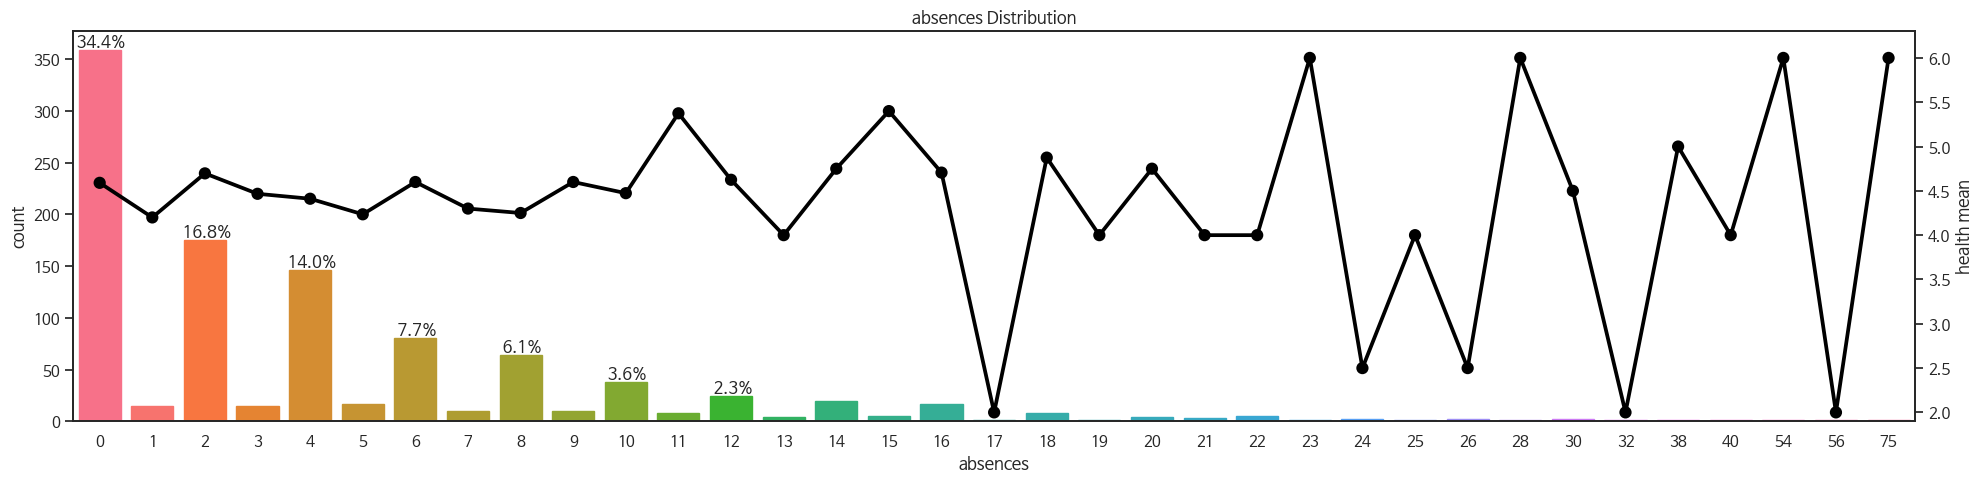

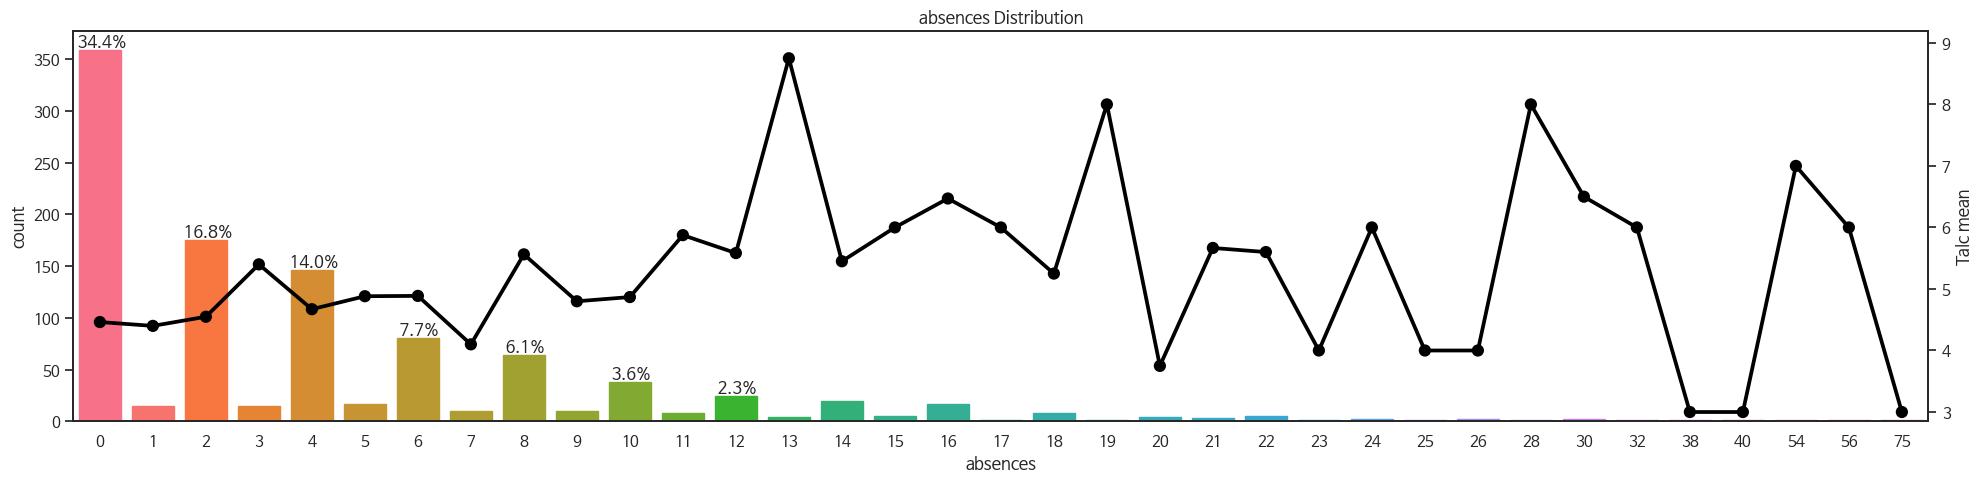

In [376]:
num_feature = ['absences']

for idx, feature in enumerate(num_feature):
    ###
    plt.figure(figsize=(20,5))
    ax = plt.subplot(1,1,1)
    crosstab = get_crosstab_mean(both, feature, target="GT_scale_rank_bin") # 교차 분석표 작성
    # ax축에 그래프 그리기
    sns.countplot(x=feature, data=both,
                 order=crosstab[feature].values,
                 ax=ax)
    # 축에 색 넣기
    for idx in range(len(ax.patches)):
        ax.patches[idx].set_color(sns.husl_palette(len(ax.patches))[idx])
    # 비율 표시    
    write_percent(ax, len(both)) 
    # ax2축에 포인트 플랏그리기
    plot_pointplot(ax, feature, crosstab,target="GT_scale_rank_bin") 
    ax.set_title(f"{feature} Distribution") # 타이틀 설정
    plt.tight_layout()
    plt.show()
    ###
    plt.figure(figsize=(20,5))
    ax = plt.subplot(1,1,1)
    crosstab = get_crosstab_mean(both, feature, target="health") # 교차 분석표 작성
    # ax축에 그래프 그리기
    sns.countplot(x=feature, data=both,
                 order=crosstab[feature].values,
                 ax=ax)
    # 축에 색 넣기
    for idx in range(len(ax.patches)):
        ax.patches[idx].set_color(sns.husl_palette(len(ax.patches))[idx])
    # 비율 표시    
    write_percent(ax, len(both)) 
    # ax2축에 포인트 플랏그리기
    plot_pointplot(ax, feature, crosstab,target="health") 
    ax.set_title(f"{feature} Distribution") # 타이틀 설정
    plt.tight_layout()
    plt.show()
    ###
    plt.figure(figsize=(20,5))
    ax = plt.subplot(1,1,1)
    crosstab = get_crosstab_mean(both, feature, target="Talc") # 교차 분석표 작성
    # ax축에 그래프 그리기
    sns.countplot(x=feature, data=both,
                 order=crosstab[feature].values,
                 ax=ax)
    # 축에 색 넣기
    for idx in range(len(ax.patches)):
        ax.patches[idx].set_color(sns.husl_palette(len(ax.patches))[idx])
    # 비율 표시    
    write_percent(ax, len(both)) 
    # ax2축에 포인트 플랏그리기
    plot_pointplot(ax, feature, crosstab,target="Talc") 
    ax.set_title(f"{feature} Distribution") # 타이틀 설정
    plt.tight_layout()
    plt.show()

In [ ]:
target_feature = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher',  
               'internet', 'romantic', 'school', 'sex', 'address', 'famsize', 'Pstatus']


for idx, feature in enumerate(bin_feature):
    plt.figure(figsize=(20,7))
    ax = plt.subplot(1,3,1)
    sns.countplot(x=feature,
                 data=both,
                 ax=ax)
    for idx in range(len(ax.patches)):
        ax.patches[idx].set_color(sns.husl_palette(len(ax.patches))[idx])
    sns.countplot(x=feature,
                 data=both,
                  hue="GT_scale_rank_bin",
                 ax=ax)
    write_percent(ax, len(both))
    plt.legend(title="Total score bin")
    
    ax = plt.subplot(1,3,2)
    sns.countplot(x=feature,
                 data=both,
                 ax=ax)
    for idx in range(len(ax.patches)):
        ax.patches[idx].set_color(sns.husl_palette(len(ax.patches))[idx])
    sns.countplot(x=feature,
                 data=both,
                  hue="health",
                 ax=ax)
    write_percent(ax, len(both))
    
    ax = plt.subplot(1,3,3)
    sns.countplot(x=feature,
                 data=both,
                 ax=ax)
    for idx in range(len(ax.patches)):
        ax.patches[idx].set_color(sns.husl_palette(len(ax.patches))[idx])
    sns.countplot(x=feature,
                 data=both,
                  hue="Talc",
                 ax=ax)
    write_percent(ax, len(both))
    plt.show()

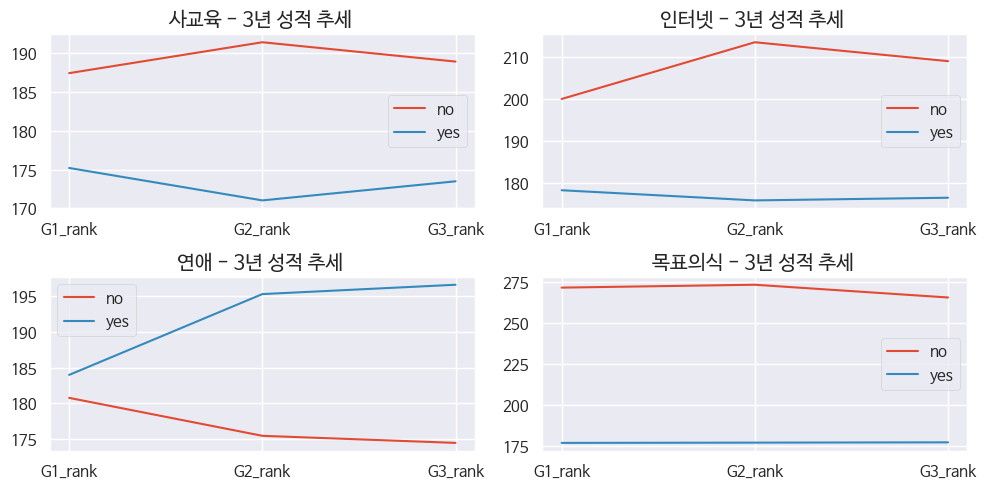

In [74]:
## 성적추이
plt.figure(figsize=(10,5))
plt.subplot(2,2,1)
df = math[["G1_rank","G2_rank","G3_rank","paid"]].groupby(by=["paid"]).mean()
plt.plot(df.T)
plt.title("사교육 - 3년 성적 추세 ")
plt.legend(df.index)

plt.subplot(2,2,2)
df = math[["G1_rank","G2_rank","G3_rank","internet"]].groupby(by=["internet"]).mean()
plt.plot(df.T)
plt.title("인터넷 - 3년 성적 추세 ")
plt.legend(df.index)

plt.subplot(2,2,3)
df = math[["G1_rank","G2_rank","G3_rank","romantic"]].groupby(by=["romantic"]).mean()
plt.plot(df.T)
plt.title("연애 - 3년 성적 추세 ")
plt.legend(df.index)

plt.subplot(2,2,4)
df = math[["G1_rank","G2_rank","G3_rank","higher"]].groupby(by=["higher"]).mean()
plt.plot(df.T)
plt.title("목표의식 - 3년 성적 추세 ")
plt.legend(df.index)

plt.tight_layout()